# Distributions

We look at neuron activation distributions

## Get Activations
We first import dependancies and run the model to get some neuron distributions

In [1]:
try: # if in google colab, download necessary python files
  import google.colab
  ! pip install -qq taker
except ModuleNotFoundError:
  pass

In [2]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from taker import Model
from taker.activations import get_midlayer_activations

In [3]:
opt = Model('facebook/opt-125m', limit=1000)
dataset = 'pile'

/home/ubuntu/taker/src/taker/model.py:143: UserWarning: Model facebook/opt-125m not tested.
  warnings.warn( f"Model {model_repo} not tested." )


- Loaded facebook/opt-125m
 - Registered 12 Attention Layers


In [4]:
data = get_midlayer_activations( opt, dataset, 1e4, collect_ff=True, collect_attn=True )

# [token, layer, neuron] -> [layer, neuron, token]
ff_activations   = data.raw["ff"].permute( (1,2,0) )
# [token, layer, attention head, attention neuron] -> [layer, attention head, attention neuron, token]
attn_activations = data.raw["attn"].permute( (1,2,3,0) ).reshape( (opt.cfg.n_layers, opt.cfg.d_model, -1) )
print( ff_activations.size() )
print( attn_activations.size() )

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

10311it [00:18, 548.27it/s]                            


torch.Size([12, 3072, 10311])
torch.Size([12, 768, 10311])


In [5]:
code_data = get_midlayer_activations( opt, "code", 1e4, collect_ff=True, collect_attn=True )

code_ff_activations   = code_data.raw["ff"].permute( (1,2,0) )
code_attn_activations = code_data.raw["attn"].permute( (1,2,3,0) ).reshape( (opt.cfg.n_layers, opt.cfg.d_model, -1) )
print( code_ff_activations.size() )
print( code_attn_activations.size() )

/home/ubuntu/taker/.venv/lib/python3.9/site-packages/datasets/load.py:1429: FutureWarning: The repository for codeparrot/github-code-clean contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/codeparrot/github-code-clean
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
10403it [00:18, 560.83it/s]                            


torch.Size([12, 3072, 10403])
torch.Size([12, 768, 10403])


In [6]:
codeless_data = get_midlayer_activations( opt, "pile_codeless", 1e4, collect_ff=True, collect_attn=True )

codeless_ff_activations   = codeless_data.raw["ff"].permute( (1,2,0) )
codeless_attn_activations = codeless_data.raw["attn"].permute( (1,2,3,0) ).reshape( (opt.cfg.n_layers, opt.cfg.d_model, -1) )
print( codeless_ff_activations.size() )
print( codeless_attn_activations.size() )

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

10585it [00:16, 623.60it/s]                            


torch.Size([12, 3072, 10585])
torch.Size([12, 768, 10585])


## Plot Distributions for Neurons
We can investigate the distribution of some random neurons in the network.

In [21]:
def plot_layer_index(activations, layer, indices, ax=None, fill=False):
    if ax is None:
        fig, ax = plt.subplots()
    for i in indices:
        label = None if fill else f"L{layer} Pos {i}"
        counts, bins = np.histogram( activations[layer][i].cpu().numpy(), bins=100 )
        mids = (bins[:-1] + bins[1:]) / 2
        if fill:
            ax.semilogy( mids, counts, label=label, alpha=0.2, linewidth=0.5 )
            ax.fill_between(mids, counts, color='skyblue', alpha=0.02)
        else:
            ax.semilogy( mids, counts, label=label, alpha=1, linewidth=1 )

def plot_activation_indices(activations, indices):
    for j in range(0, opt.cfg.n_layers, 7):
        fig, ax = plt.subplots()
        plt.title(f"layer {j}")
        plot_layer_index(activations, j, indices)
        plt.show()

def plot_multiple(activations, layer, indices, labels, xlim, ylim, fill=False):
    n_plots = len(activations)
    fig, axes = plt.subplots(1, n_plots, figsize=(10, 4))
    axes[0].set_ylabel(f"Unnormalized Probability Density")
    for i, ax in enumerate(axes):
        ax.set_xlabel(f"Neuron value in {labels[i]}")
        plot_layer_index(activations[i], layer, indices, ax, fill)
        ax.semilogy([0, 0], ylim, ":k", alpha=0.01)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if not fill:
            ax.legend()
    plt.show()





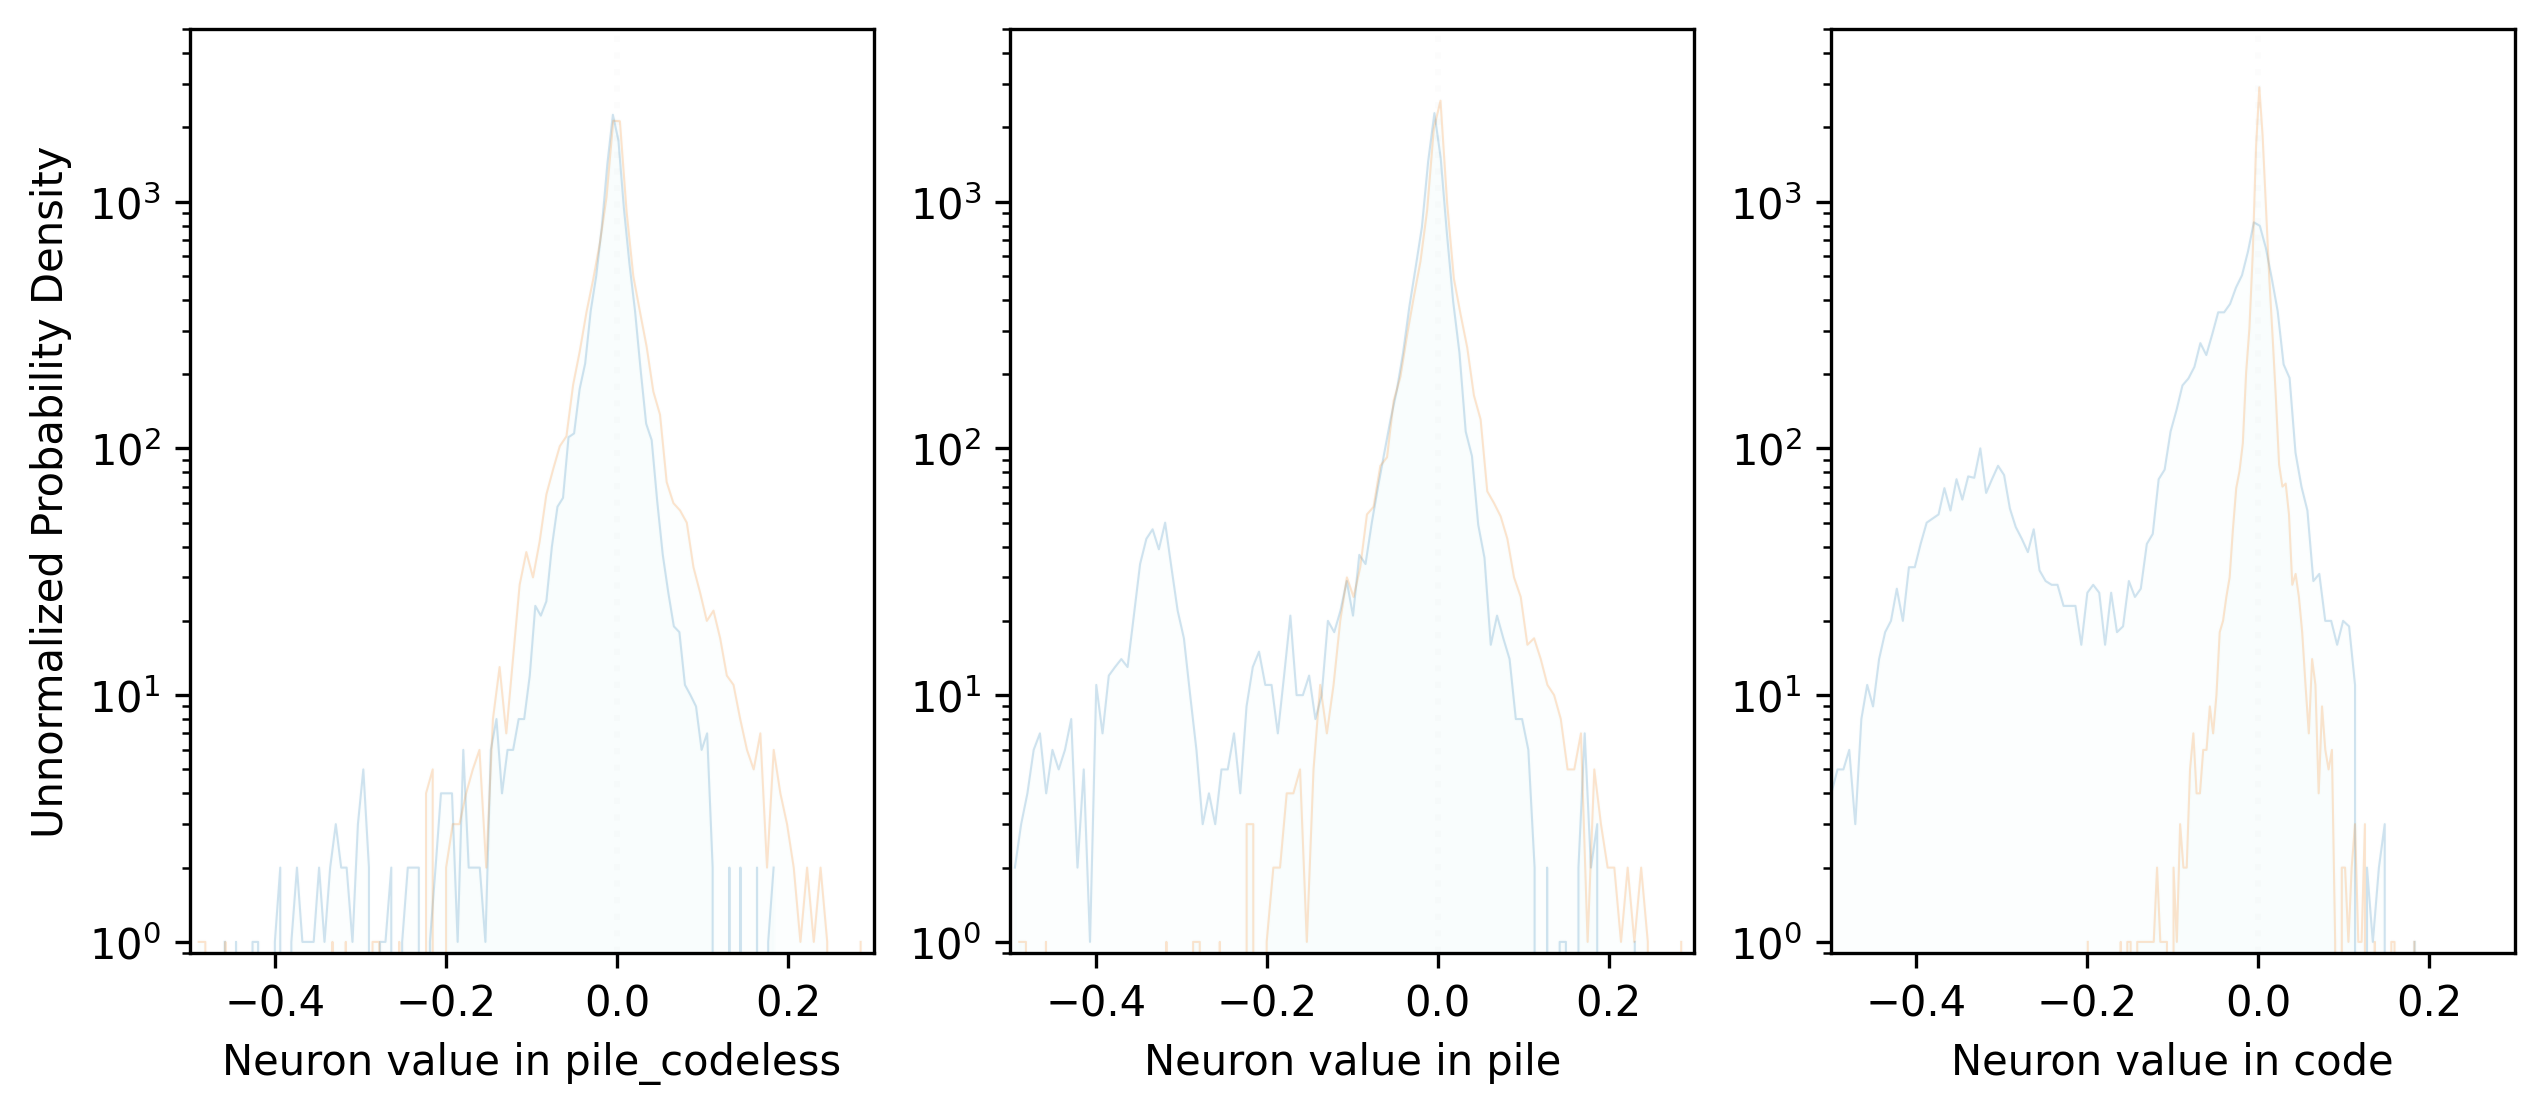

In [8]:
#plot_layer_index(ff_activations, 2, [100, 124, 240, 424])
#plt.legend()
#plt.show()
#plot_layer_index(attn_activations, 2,[100, 124, 240, 424])
#plt.legend()
#plt.show()
# plot comparison
plot_multiple([codeless_attn_activations, attn_activations, code_attn_activations],
              2, [240, 737], ["pile_codeless", "pile", "code"], [-0.5, 0.3], [0.9, 5e3], True)

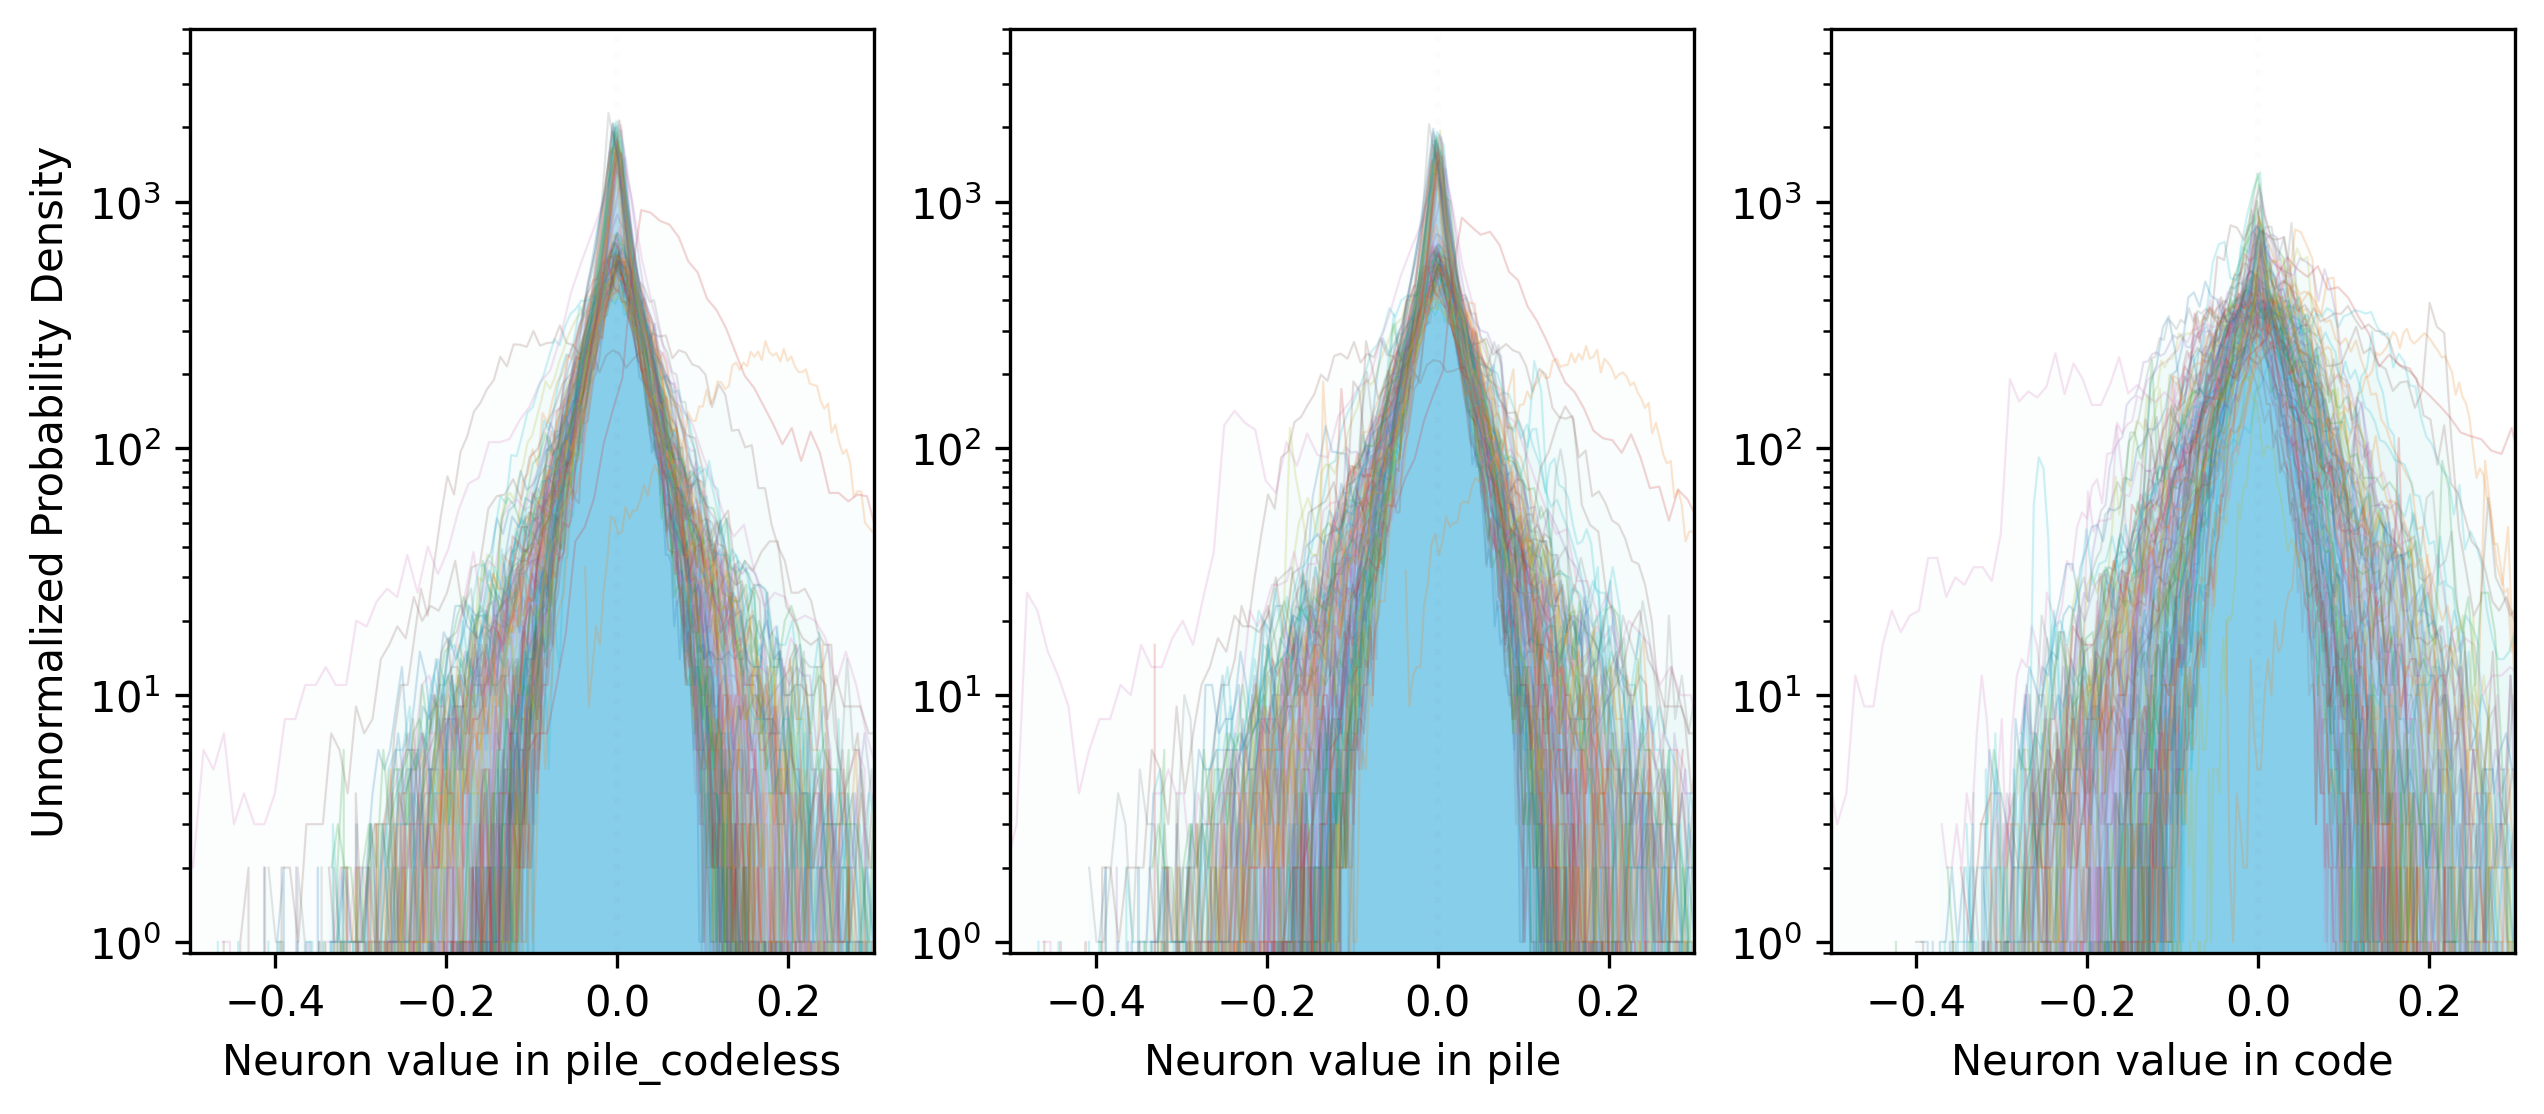

In [9]:
# Plot many neurons in one graph
plot_multiple([codeless_attn_activations, attn_activations, code_attn_activations],
              2, range(100), ["pile_codeless", "pile", "code"], [-0.5, 0.3], [0.9, 5e3], True)

In [10]:
scores = code_attn_activations.abs().mean(axis=-1) / codeless_attn_activations.abs().mean(axis=-1)
print(scores.shape)
idx = np.argsort(scores[2])
print(idx[:5], idx[-5:])

torch.Size([12, 768])
tensor([737, 392, 403, 411, 428]) tensor([617, 582, 218, 634, 240])


# Code is not useful from here

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/bin/bash: /home/ubuntu/taker/.venv/bin/pip: /home/ubuntu/untape/.venv/bin/python: bad interpreter: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time taken: 1.0028252601623535s


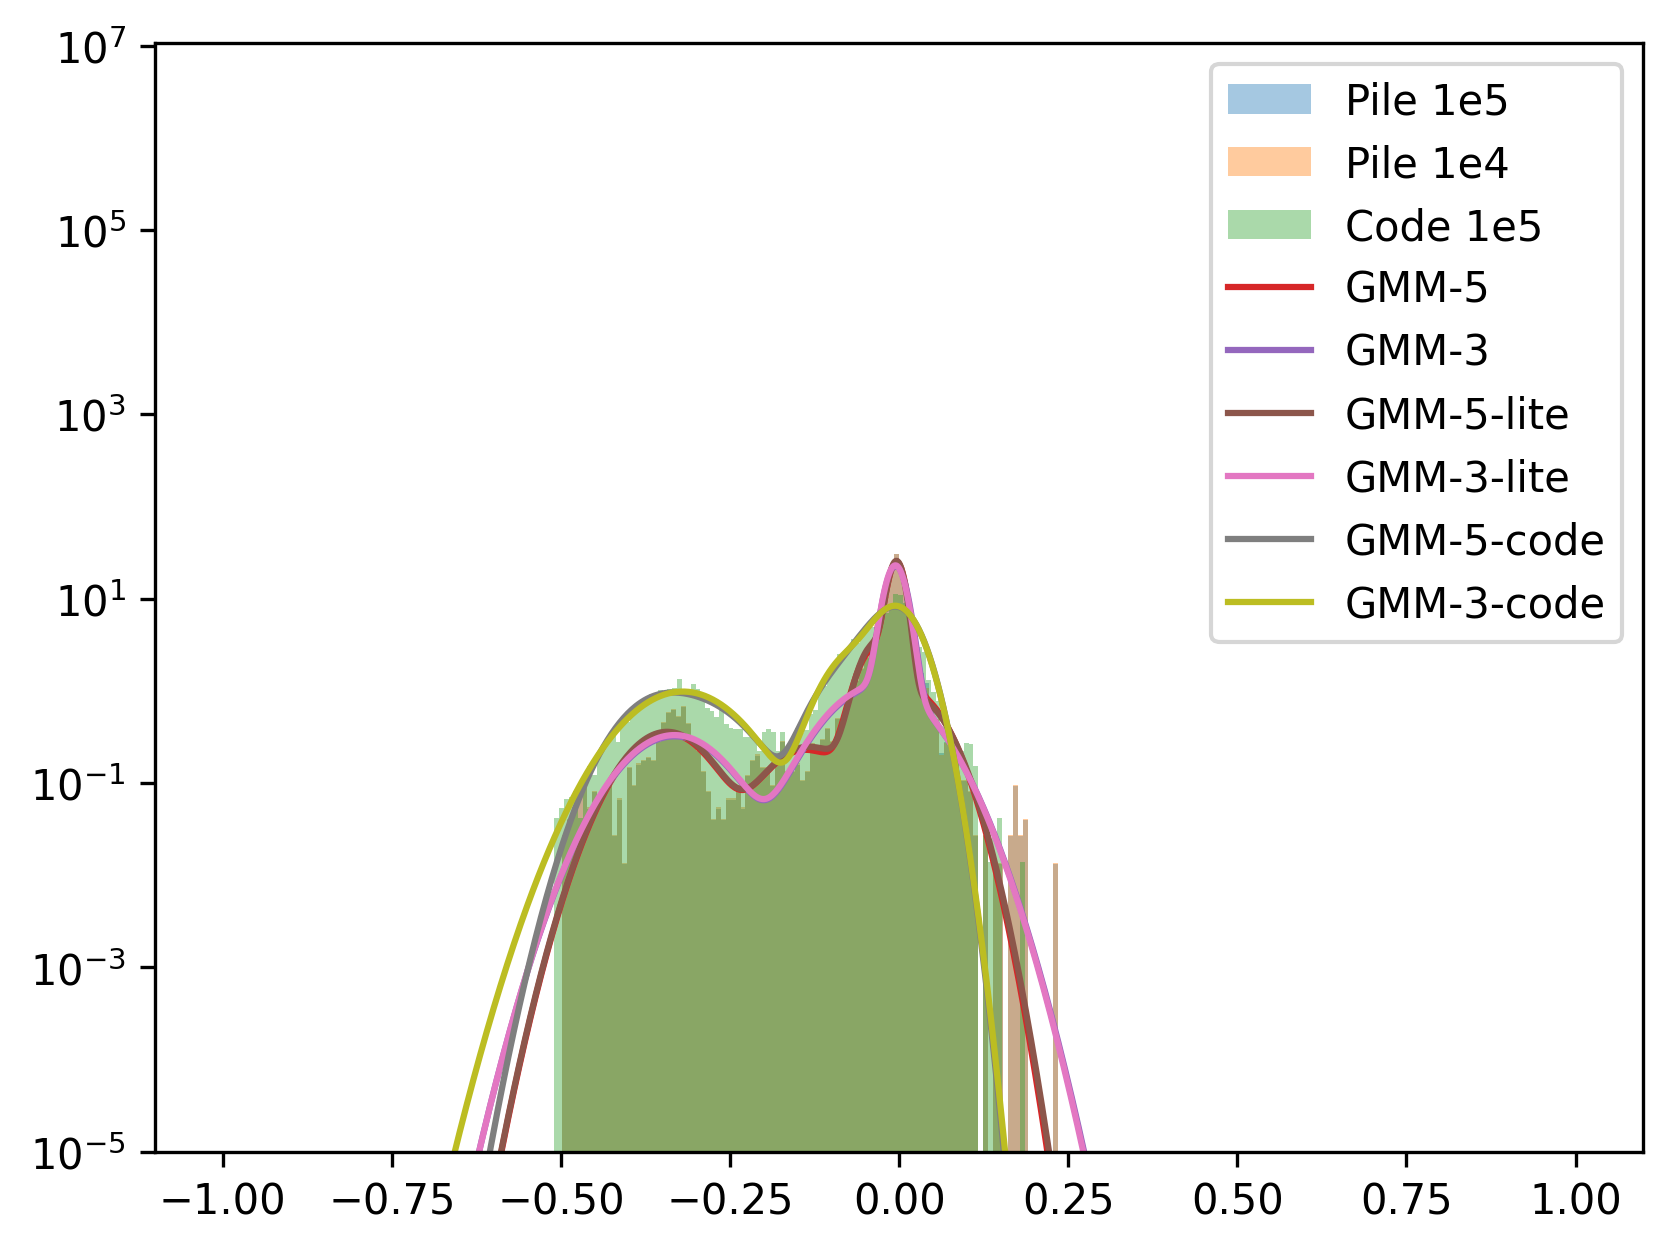

In [11]:
!pip install scikit-learn -qqq
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import time

# Generate example data
np.random.seed(42)
#data1 = np.random.normal(0, 1, 1000)
#data2 = np.random.laplace(4, 1, 1000)
#data = np.concatenate((data1, data2))
data_p = attn_activations[2][240].numpy()
data_c = code_attn_activations[2][240].numpy()

# Fit a Gaussian Mixture Model with 2 components
t0 = time.time()
gmm3 = GaussianMixture(n_components=3).fit(data_p.reshape(-1, 1))
gmm5 = GaussianMixture(n_components=5).fit(data_p.reshape(-1, 1))
gmm5_lite = GaussianMixture(n_components=5).fit(data_p[:10000].reshape(-1, 1))
gmm3_lite = GaussianMixture(n_components=3).fit(data_p[:10000].reshape(-1, 1))
gmm3_c = GaussianMixture(n_components=3).fit(data_c.reshape(-1, 1))
gmm5_c = GaussianMixture(n_components=5).fit(data_c.reshape(-1, 1))
print(f"Time taken: {time.time()-t0}s")

# Evaluate the GMM on a grid
x_range = np.linspace(-1, 1, 1000)
log_prob_fn = lambda gmm_i : gmm_i.score_samples(x_range.reshape(-1, 1))
density_fn = lambda gmm_i : np.exp( log_prob_fn(gmm_i) )
d3  = density_fn(gmm3)
d5  = density_fn(gmm5)
d5_lite = density_fn(gmm5_lite)
d3_lite = density_fn(gmm3_lite)
d5_c = density_fn(gmm5_c)
d3_c = density_fn(gmm3_c)

# Plot histogram and GMM
plt.hist(data_p, bins=100, density=True, alpha=0.4, label='Pile 1e5')
plt.hist(data_p[:10000], bins=100, density=True, alpha=0.4, label='Pile 1e4')
plt.hist(data_c, bins=100, density=True, alpha=0.4, label='Code 1e5')
plt.semilogy(x_range, d5, label='GMM-5')
plt.semilogy(x_range, d3, label='GMM-3')
plt.semilogy(x_range, d5_lite, label='GMM-5-lite')
plt.semilogy(x_range, d3_lite, label='GMM-3-lite')
plt.semilogy(x_range, d5_c, label='GMM-5-code')
plt.semilogy(x_range, d3_c, label='GMM-3-code')
plt.ylim(1e-5, None)
plt.legend()
plt.show()


In [12]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

def get_gmm(head, pre_out_index, n_components=5):
    data_p = attn_activations[head][pre_out_index].numpy()
    data_c = code_attn_activations[head][pre_out_index].numpy()
    gmm_p = GaussianMixture(n_components=n_components).fit(data_p.reshape(-1, 1))
    gmm_c = GaussianMixture(n_components=n_components).fit(data_c.reshape(-1, 1))
    return gmm_p, gmm_c

def plot_gmm(gmm, label):
    x_range = np.linspace(-1, 1, 1000)
    log_prob_fn = lambda gmm_i : gmm_i.score_samples(x_range.reshape(-1, 1))
    density_fn = lambda gmm_i : np.exp( log_prob_fn(gmm_i) )
    d = density_fn(gmm)
    plt.semilogy(x_range, d, label=label)

def get_kl_from_gmm(gmm_a, gmm_b, verbose=False):
    # Number of samples for Monte Carlo approximation
    n_samples = 10000

    # Samples and weighing based on samples
    samples = gmm_a.sample(n_samples)[0]
    weights = np.abs(samples)

    # Calculate probability densities of both GMMs for the given samples
    log_prob_density1 = gmm_a.score_samples(samples.reshape(-1, 1))
    log_prob_density2 = gmm_b.score_samples(samples.reshape(-1, 1))

    # Compute KL divergence for each sample
    kl_divergence = log_prob_density1 - log_prob_density2

    # Weight KL divergence and normalize by the sum of the weights
    weighted_kl = np.mean(weights * kl_divergence)

    if verbose:
        print(f"Approximate KL divergence: {kl_divergence.mean()}")
        print(f"Weighted KL divergence: {weighted_kl}")

    return weighted_kl


def get_kl(head, pre_out_index, n_components=5):
    gmm_p, gmm_c = get_gmm(head, pre_out_index, n_components)
    return get_kl_from_gmm(gmm_c, gmm_p)

def get_kl_and_plot(head, pre_out_index, n_components=5):
    gmm_p, gmm_c = get_gmm(head, pre_out_index, n_components)
    get_kl_from_gmm(gmm_c, gmm_p, True)
    get_kl_from_gmm(gmm_p, gmm_c, True)
    plot_gmm(gmm_p, "gmm_p")
    plot_gmm(gmm_c, "gmm_c")
    plt.legend()
    plt.xlim(-1, 1)
    plt.ylim(0.001, None)

w_kl = []
for i in tqdm(range(768)):
    w_kl.append( get_kl( 2, i, 5 ) )


  0%|          | 0/768 [00:00<?, ?it/s]

100%|██████████| 768/768 [07:59<00:00,  1.60it/s]


In [13]:
w_kl_saved = [0.0005036452406572791, 0.0176678578536948, 0.005513954403649118, 0.000527963950760443, 0.004348886817200607, 0.0006559568799340309, 0.008173861859301567, 0.0014097556547478863, 0.0030938224534713494, 0.0007510347555736573, 0.0015265382180928637, 0.002632538920610903, 0.008022978552784495, 0.0036846092528067644, 0.019657201907506493, 0.002064976981188971, 0.0020394485335304344, 0.00031698444151821096, 0.0015869811214774708, 0.007471853607175917, 0.00012771875752685434, 0.007203737914315268, 0.001152745744426814, 0.0012742081051484923, 0.0034184565312056405, 0.0011345963375765287, 0.022706625183480614, 0.03194395120868619, 0.004586516143092097, 0.04692258423437627, 0.002391985709617473, 0.0009516267274888368, 0.0013408230689909131, 0.0020250080453706716, 0.0009151650773578822, 0.021519395434048575, 0.006135914928679554, 0.0010364176103982228, 0.0009933639054327478, 0.012865995018846763, 0.006220735098021594, 0.0037786992571088546, 0.0006052446872588885, 0.0018535118306724177, 0.00526637209011387, 0.011488359658066641, 0.010397012732486109, 0.003608209298825939, 0.00907128293208383, 0.003105951975123253, 0.0004910651574791822, 0.0015002841677757496, 0.0005547818270758303, 0.0004518813104177275, 9.292813577304427e-05, 0.019785251141396322, 0.0006798522990224848, 0.00031834412195061353, 0.009902166204969072, 0.001142867738582525, 0.0015216753591344079, 0.013258829958980095, 0.0010306642005170948, 0.0005730461284087543, 0.0061474247126292614, 0.006161436323083323, 0.00369247131705294, 0.009020517405889238, 0.008529394836489191, 0.013911158191123246, 0.012378002992861382, 0.0183424902580135, 0.0029143013983735293, 0.009018597920361925, 0.013550503121816838, 0.008053408583276599, 0.0067104597311941116, 0.008214295050988593, 0.014004891719713728, 0.012959270579296274, 0.016279599234954183, 0.0155485920568239, 0.004041478217584684, 0.003596084007181435, 0.0065806043169557935, 0.004034870962866466, 0.02872194418983008, 0.006283717827967983, 0.007650771460040416, 0.0026676892360109382, 0.006894363421017473, 0.014508948148494683, 0.003853820237918743, 0.016053407095968295, 0.01545688286587385, 0.029050885576120365, 0.0025237944195975743, 0.004696907491588847, 0.01512035830346853, 0.010079462411069107, 0.007972216247192668, 0.005857238194355342, 0.008132259108676465, 0.0023517917224870418, 0.05219879363479133, 0.006742403936201788, 0.008450521314399887, 0.020252799784805906, 0.017113522461256633, 0.013815229567436471, 0.003991555648837118, 0.006301774620958024, 0.003471688166509192, 0.014444904880961644, 0.027450243098120775, 0.008734466560834578, 0.012936054538379545, 0.013165237492594756, 0.010367068408210453, 0.03538457572109165, 0.018925969950213943, 0.013743491337953785, 0.019377420301798565, 0.0139539594349732, 0.006874550292248927, 0.004736194420973804, 0.01761486017878759, 0.007980557561033044, 0.0013338300594506062, 0.005747044479995423, 0.002618797011918325, 0.002051539848682445, 0.004774473406321762, 0.0034869142355728596, 0.011352245723169535, 0.0016649027165392771, 0.0041652217314057625, 0.004600871117961086, 0.007382089275773699, 0.005068868618730458, 0.006034252952383456, 0.004044985047426666, 0.0014558780786041957, 0.0053881206692448155, 0.007133935188871929, 0.0020487869173046237, 0.016976181031928148, 0.0012394535423273058, 0.08515555264240604, 0.003009566492530986, 0.02170549567452168, 0.006392919334206179, 0.0018992482394669266, 0.0014906091175162237, 0.009573274252810085, 0.001855558692127495, 0.00441259241659031, 0.008435906213459014, 0.00174280648653581, 0.021751261517392987, 0.0024398529471636064, 0.0067818311536984735, 0.0045734178711148606, 0.004608727136221406, 0.003006039935833199, 0.005758769902804419, 0.0036404127312324656, 0.0015240899206198336, 0.0022019719354766615, 0.004458075869131867, 0.001736753427995005, 0.0029839299227117175, 0.004326780920301359, 0.0037082812349013955, 0.003526280100752807, 0.0058816297697725185, 0.00239349647223078, 0.003173753223888398, 0.004118343706457412, 0.002236735244121718, 0.009018116305577695, 0.0021635207419983442, 0.006778466426378879, 0.0024919402717081727, 0.003691707095414144, 0.001655289823621334, 0.00400861137374728, 0.0033913883778792964, 0.008858925320539, 0.002880515828460228, 0.00011256433178126212, 0.002455130999062471, 0.005545290819862259, 0.015558087988418843, 0.005566733437721622, 0.0014276733243518789, 0.007890704445515364, 0.0038638045867838288, 0.007459777911954088, 0.0033518433455382362, 0.023027586871763775, 0.008644100851755668, 0.004032629209411595, 0.0031692566131162766, 0.0014484435713735706, 0.0067656750594679484, 0.004654645990607786, 0.002768462857364626, 0.010191188575046578, 0.003994853448548857, 0.017035230568214085, 0.006557845971915502, 0.009298114425290084, 0.0050204537916285555, 0.004682043210317917, 0.022944797014457955, 0.006040783834423892, 0.002852343293991052, 0.027983051189752108, 0.014188582363758293, 0.002137922480248745, 0.019872472035160543, 0.009086006146875502, 0.001525044781575194, 0.004305464750746248, 0.017567820497989856, 0.01606520351790064, 0.011187718912317571, 0.0028003693443314232, 0.009729727753686804, 0.011981829219470217, 0.027931675376560047, 0.02171829217947445, 0.009137216445418095, 0.020416057032800236, 0.005707147587060551, 0.0163033794232992, 0.009724774369246411, 0.0022740525873358574, 0.004152656887175503, 0.04447583913862335, 0.0031927782587876574, 0.004307981574028304, 0.005020361017444963, 0.0123936006975089, 0.005890915532466907, 0.009770304185073346, 0.01280187160491442, 0.004790948341479918, 0.01414474163112262, 0.01234427222493586, 0.0219204737591855, 0.004570189821283327, 0.021505232018183676, 0.015459096346916135, 0.010843967222522087, 0.0007028149861834216, 0.006330325673225013, 0.006294404068426922, 0.0010459824539025009, 0.003033726084684029, 0.00339514111535226, 0.0011571187198025359, 0.001095888275603515, 0.0018745225243810893, 0.0044768745843851215, 0.007074139487585024, 0.0048429929884677, 0.0027125306726385294, 0.004629768451056811, 0.004421149047005933, 0.006765404094220836, 0.000900449892988074, 0.008799266955216453, 0.0012040824111382627, 0.002793295810157569, 0.0025867794599245984, 0.003664461546490521, 0.0052845150126227865, 0.002574200148564969, 0.0007115667521231593, 0.0022584518619100697, 0.0020979952200818872, 0.000899117181400878, 0.000597915749322113, 0.002291841769378707, 0.003493475428154067, 0.0021524871594736043, 0.00066824064765213, 0.0006515751879332304, 0.0029068796628745827, 0.0017582371748472404, 0.003362716155140974, 0.0026874371050204797, 0.0007710202783425642, 0.0029236074292407384, 0.0011603147488393121, 0.006509767413327444, 0.0033083532256751942, 0.008804905936232532, 0.0008742269852556607, 0.001186517751283002, 0.003787427454042751, 0.008895129981176317, 0.0030044918503670335, 0.0014714097874413538, 0.0010124529669977673, 0.005888264256297734, 0.0008326768851833208, 0.0006062123187893058, 0.0017452572030245157, 0.0025362656251935985, 0.0017280766531491995, 0.000961228753215431, 0.0026623014903353246, 0.0012043345354986567, 0.0022058938502410594, 0.002037445799057851, 0.0014297308388576924, 0.0013599990338474446, 0.003410914243022189, 0.0052557188975763825, 0.01741742118800243, 0.02196891701593723, 0.012426037136952535, 0.002140452440980765, 0.004716589259588597, 0.0028574805442684965, 0.0027546791494548256, 0.0009282300462915216, 0.002197202900136211, 0.00276700825791907, 0.009086064410374049, 0.000428304437851877, 0.0005668321818998082, 0.001273941019475663, 0.0082949473190952, 0.01710134831342877, 0.008519079040285482, 0.0011469393411313686, 0.009485074766176665, 0.004214859400593343, 0.0026151868491954716, 0.0020442361797093087, 0.010149954137835192, 0.002244611490918864, 0.0011962349448995347, 0.003135617247439699, 0.00034571386587542517, 0.001267121635721952, 0.0009349560707364435, 0.004990792330744582, 0.0018932384856421216, 0.004032221996563466, 0.004063921777882478, 0.0030687558943873, 0.0021177976076236383, 0.0007729881207181126, 0.0010919162042577182, 0.007879064241050782, 0.001149770712014033, 0.006151566515600906, 0.0019905309369305873, 0.007591032101091205, 0.0037087070963844645, 0.003849745658908825, 0.01757636175099822, 0.003167265986393093, 0.0019861480635297315, 0.0003388212649655361, 0.01078800620930478, 0.004048033340732056, 0.00046134403319736877, 0.002698580441531837, 0.0005666332979439835, 0.005426621063170314, 0.001120376208326024, 0.009149250219431224, 0.004159086329195202, 0.0007313642578458824, 0.0012056501157836248, 0.0006698489141359278, 0.005483307494132949, 0.004424227381708284, 0.004926671313016584, 0.0027755644389660023, 0.0007022148414071547, 0.003984507701736865, 0.05209633397410886, 0.03811412195945987, 0.002402557248717982, 0.004308268114572374, 0.002561248749670919, 0.006152227959023089, 0.004059318680456126, 0.006166170391751878, 0.0017291239658742902, 0.007243148017706436, 0.0011343230970975707, 0.023561119428142742, 0.006044491742685982, 0.04236507509601983, 0.010090205660331449, 0.003903183724826427, 0.0013733855792500524, 0.009138885068048564, 0.0006818542799913042, 0.0032888131094971447, 0.021504036167058982, 0.0032623165860606613, 0.0022504288140332202, 0.00518008811299836, 0.0012024833108591239, 0.001001364636041594, 0.0037866654477971147, 0.0028427625697730993, 0.015673306618313152, 0.0020792631914872614, 0.0010989417827417926, 0.019811379131453245, 0.007384272886829166, 0.006902796467359574, 0.027053419690284537, 0.008575510743011274, 0.010220982044854152, 0.010296390178976298, 0.006622778956551702, 0.001414036959404397, 0.0019918378926871197, 0.010667963239606693, 0.0015768525219224286, 0.002414393204397445, 0.00034986944188717675, 0.0024504372529830956, 0.022157100942038866, 0.006907569720731759, 0.0012704014233032989, 0.013884008069203698, 0.0033680966557221195, 0.0037543080526398704, 0.0023351231814668924, 0.0033624664312083196, 0.0028158162875744725, 0.003999828955234857, 0.008761646595994252, 0.001371174673115522, 0.019833672686661884, 0.0017328136300372588, 0.006576093706573493, 0.000938870128900817, 0.0019761169141597652, 0.0032092777775933235, 0.003190764246666503, 0.001334321259406228, 0.011775257446119007, 0.0006907325242072326, 0.0006148941459996833, 0.0007630018194058966, 0.0011505721639438514, 0.0006784150190054752, 0.00039056346965108416, 0.0009587351094436518, 0.005481488807943743, 0.000695120864308957, 0.0020289230335883315, 0.0006209040553306726, 0.005311705241252972, 0.0015750765527704894, 0.0015066502635850076, 0.006635700011860244, 0.005965220431051652, 0.00267428310158836, 0.001678295550751917, 0.0020298118233140847, 0.003043082724228268, 0.0005606977146310549, 0.0010970229399874308, 0.0002793857604183981, 0.003324803340201522, 0.0017565356604657776, 0.005795043163556051, 0.001940333825002048, 0.0025494645697939633, 0.008612164120888813, 0.00470642674805188, 0.0020510616322659833, 0.004598444044064289, 0.003062921007690181, 0.001680022679498238, 0.005670819037238663, 0.0016936787711001986, 0.001891374066272733, 0.0011741275959621757, 0.0006561004505201346, 0.0005940097458549246, 0.0036000858021302566, 0.011049668462638329, 0.0005145527866775558, 0.0005822138220103115, 0.0017287545922612317, 0.005285179210407495, 0.0009975538636393085, 0.003692242042610048, 0.000848005905672467, 0.002881877063722837, 0.002032477618943384, 0.001130110616838761, 0.0018181996389104425, 0.0016759213853798963, 0.001234330396610939, 0.0008200283981742295, 0.002046186534304265, 0.004279657726073614, 0.0007394986387733798, 0.0024431932027590346, 0.00647610810393814, 0.000232476078423791, 0.0010627243448216128, 0.0029097274841198865, 0.00148642982404679, 0.0010596838601924254, 0.0017146045596504985, 0.003231173383130357, 0.00039061144980376733, 0.00015836606287575404, 0.0007879903540832728, 0.0004403964323556844, 0.009679805865047898, 0.002779112302043655, 0.0036329295953563684, 0.02865894739231148, 0.0007237809703795691, 0.00149114736203364, 0.001684497778294083, 0.007800342260476274, 7.908030557965973e-05, 0.0015302622447370628, 0.0054935078997468585, 0.0021345627972655587, 0.014504597307628488, 0.0021661833136534785, 0.00010421302157673752, 0.00200402065237763, 0.003350429414045456, 0.0006762264928478365, 0.0024197572449376303, 0.001921289664538819, 0.0002359225432754762, 0.0028328554536554717, 0.0006174768930589411, 0.0004155243504993009, 0.000896343081811086, 0.008233206985491513, 0.0010503346870197655, 0.0016156998943431336, 0.0029387696008094134, 0.005056419328965029, 0.00034949947351895004, 0.0006375575357971846, 0.008134856727803765, 0.004758855089673983, 0.0004876277352279475, 0.013530766763278471, 0.0014519533838393708, 0.00031114686727167195, 0.00042136018951952504, 0.002746299775069818, 0.001990628729686134, 0.002389031918051486, 0.008753001269986523, 0.023315817013435523, 0.0005267623285531086, 0.0015109002662857618, 0.043510611389464646, 0.005703741407603898, 0.0006952179909104425, 0.0027288823509944325, 0.0019260938607371571, 0.005306754882040506, 0.028022721574165015, 0.038221653666749275, 0.012279941747380816, 0.05176870893326685, 0.0043323264499374615, 0.008212809354116845, 0.005060892618283988, 0.012342074954614101, 0.017321147515981662, 0.001050611136629056, 0.00796093473235601, 0.007461028425942588, 0.002776929193004275, 0.007906860565766023, 0.012016138165801602, 0.0015377952683485678, 0.014520199730451428, 0.008494997645709412, 0.005633664296677433, 0.006774212124033574, 0.038318180009313814, 0.020417360994371053, 0.0005783440313949066, 0.013844770385453366, 0.0015209943783131416, 0.03649318909469547, 0.014037893870513468, 0.004893519585808227, 0.014398890735303429, 0.008853071063199876, 0.012367385090759445, 0.00668479380149095, 0.011781939095076879, 0.007215829504921864, 0.020055179674589724, 0.00485920230730687, 0.0016461353150299194, 0.03528194361332975, 0.04399430837832564, 0.00797616725477513, 0.0086862665471789, 0.00835664193129879, 0.0017842825392402058, 0.006654857307919314, 0.013756793611604725, 0.001279953271700034, 0.013377859375814344, 0.006780822870513422, 0.003743157892577939, 0.03930921047933108, 0.038878162506379745, 0.011186837072164828, 0.016921965321209015, 0.010834682982506484, 0.025310303127818876, 0.03770572483150587, 0.008879543167272989, 0.0038303893914453453, 0.0025789574470886003, 0.0316424559219521, 0.005686100193153177, 0.0002771478942161495, 0.0003580715255727755, 0.005118817141915537, 0.006275753371605998, 0.0010480373826181342, 0.00010646361402921476, 0.001417116497942833, 0.001295111226534665, 0.026558936539036584, 0.00025414710468808663, 0.002063132375466713, 0.0036750091315318457, 0.018761930820024447, 0.0022985698763055167, 0.000880005900219839, 0.0027007195526916813, 0.0047627499415127325, 0.0012158630675410255, 0.0008067416658104112, 0.003048247022606135, 0.0002260156834820797, 0.00047354064185986083, 0.0068125248932152825, 0.0001333386635123578, 0.00018951390638952085, 0.0028520216562171736, 0.00016501965515895766, 0.0011731291765383965, 0.0007045208262614574, 0.011208665081740213, 0.0007288516826237698, 0.0004741622386096173, 0.003770684235334427, 0.003590176139606862, 0.0015556879466774498, 0.04016779936516639, 0.0007625259682265959, 0.00019574372671133172, 0.0007330061763875103, 0.0006415813069474925, 0.0007564918927402429, 0.0005012174263102875, 0.0011005176135979863, 0.0003623823098405543, 0.0027907443794124554, 0.002213852320713902, 0.00022717129700966675, 0.0022999714455696953, 0.0003365120813671912, 0.0033335623819994065, 0.011692190003103734, 0.0222371475939501, 0.0035790057318773097, 0.0019080826479961819, 0.02888862812868652, 0.00029642539149460367, 0.0015425920550460363, 0.0017009071379433145, 0.0040161430638498245, 0.0018365848180824347, 0.0014858361632134704, 0.0015750896704002733, 0.001648368198550675, 0.0005421555365785722, 0.001405413908191021, 0.008664237872058887, 0.006613338160359101, 0.0010210254223333268, 0.0023072573477441434, 0.0017755192899478172, 0.0011535282006976803, 0.0019755369403451763, 0.0009340149669379922, 0.002909290562016094, 0.002007021695299362, 0.01004715462225901, 0.0017315888329102903, 0.0008918272642241676, 0.0012501434079156776, 0.0012816489375117584, 0.007688961055296888, 0.002042075357194951, 0.0037301071796514637, 0.0013505961387012067, 0.0010980652180010272, 0.0014221095103537852, 0.0005445096135265963, 0.003037879272586343, 0.0015627495727067217, 0.0018873858524469799, 0.003449368725771689, 0.0018629317876088485, 0.007723404258387396, 0.001957422600690262, 0.0014115066294555357, 0.015143634607822294, 0.002230115138271803, 0.002250325236859768, 0.0010401265428412415, 0.004778960171356808, 0.010426145569515058, 0.0016736521019614433, 0.0007275810573365288, 0.0008345835913973939, 0.0011775221501281717, 0.0010165680240476612, 0.0014532930463405792, 0.005724943651053719, 0.002734751212612327, 0.0009441454237845027, 0.005080239344830473, 0.0018130738916907535, 0.0017206483342540454, 0.00134108668120608, 0.003839767894861574, 0.0017128001980018293, 0.0006782961669229428, 0.0009597297512269737, 0.0005061864009087892, 0.0013260179153216124, 0.0015684985053222137, 0.0008088807221458786, 0.002856037248131923, 0.0023062482354451845, 0.00795480529562004, 0.0009204329778562699, 0.0033356230830699166, 0.002448927476082168]
print(w_kl)

[0.001679970450135228, 0.04000202550111184, 0.006679197970749398, 0.001212683099385238, 0.0054917461717887365, 0.001170638429125195, 0.011541717104331542, 0.003601701694206633, 0.005746577186005002, 0.0004053733814266347, 0.00475316096384572, 0.005556911175257333, 0.03472241184070443, 0.0043711141388844, 0.0410808018062087, 0.0003621541321229986, 0.004195048855864452, 0.0007177550917362913, 0.0035951342419694877, 0.0068942903734173985, 0.0008233087899325983, 0.009559491159179145, 0.0012568758006851965, 0.00410328555433198, 0.007973300809234593, 0.0018182318837745848, 0.060930532995927406, 0.04738281365332838, 0.005370767473107196, 0.05827708904283948, 0.0031322730540878215, 0.000994504930109978, 0.0021771589683876147, 0.010370658554445734, 0.0005854681014901237, 0.026446546144564743, 0.01575429943807205, 0.006387764483109365, 0.004364241476851891, 0.017718573627155027, 0.006356829891728035, 0.006347575086603024, 0.0009027691873283501, 0.000981937007337592, 0.004820659621592364, 0.01277

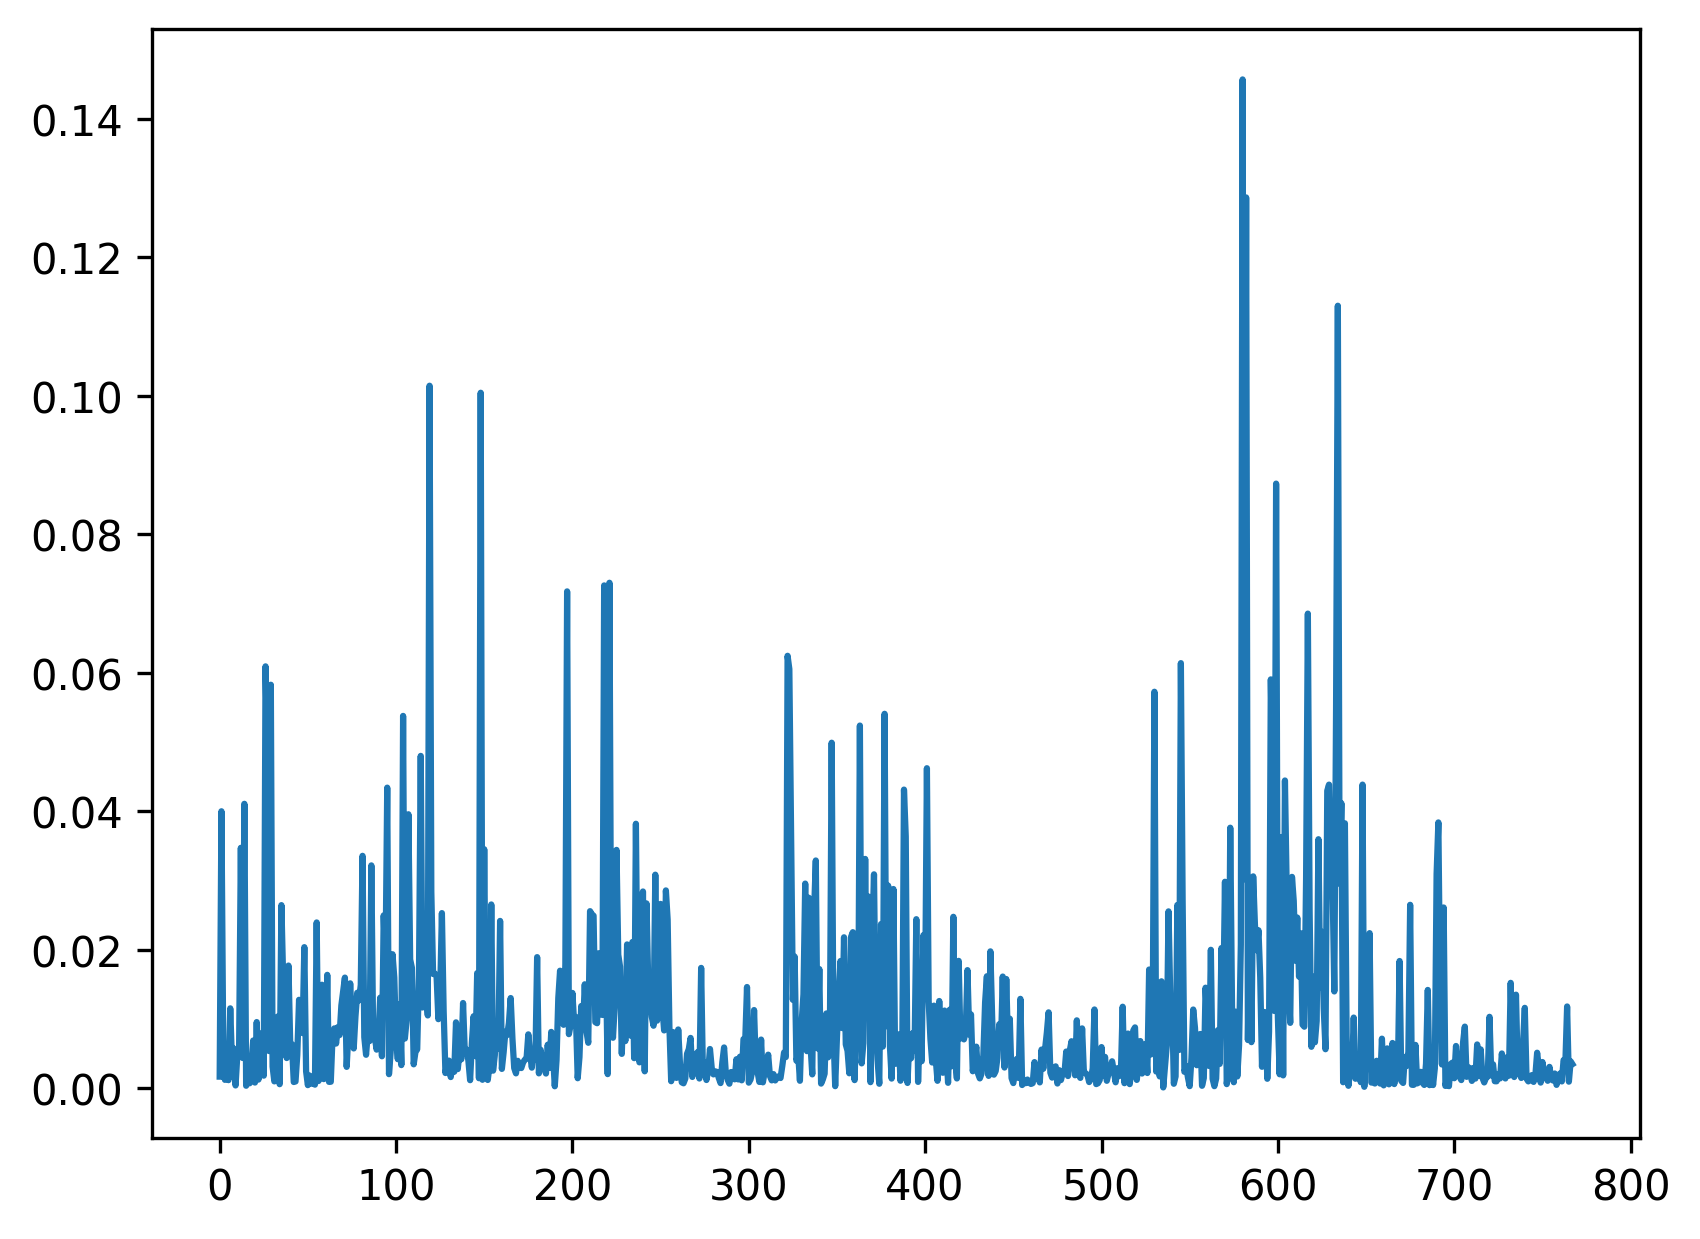

In [14]:
plt.plot(w_kl)

In [16]:
#plt.plot( data["attn"]["ff"][] )

/home/ubuntu/taker/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1986: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


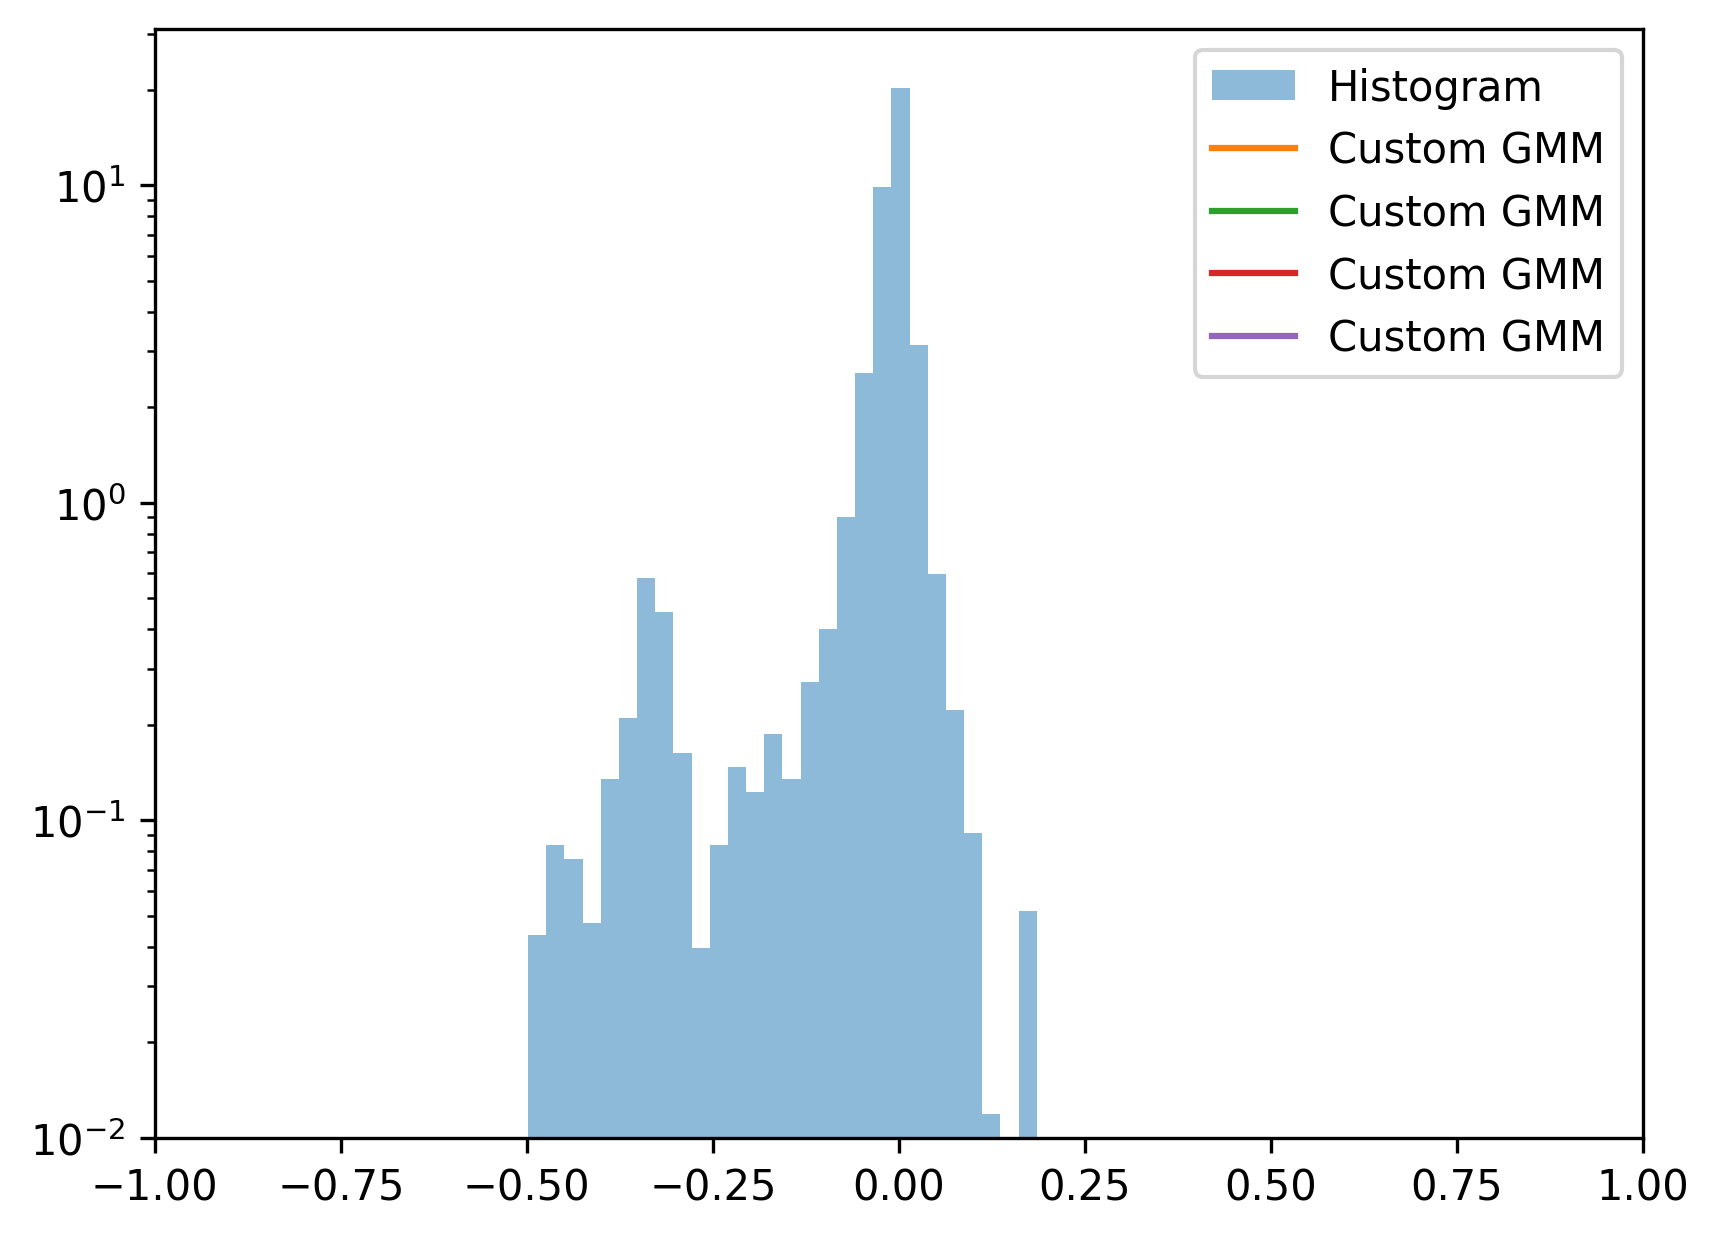

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, laplace

# Generate example data
np.random.seed(42)
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.laplace(4, 1, 1000)
data = np.concatenate((data1, data2)).reshape(-1, 1)

def double_exponential(x, loc, scale):
    return laplace.pdf(x, loc, scale)

def custom_gmm_pdf(x, params, n_components=3):
    weights, means, scales, de_loc, de_scale = np.split(params, [n_components, 2 * n_components, 3 * n_components, 3 * n_components + 1])
    gmm_pdf = np.sum([w * norm.pdf(x, mean, scale) for w, mean, scale in zip(weights, means, scales)], axis=0)
    de_pdf = double_exponential(x, de_loc, de_scale)
    return gmm_pdf + de_pdf

def custom_loss(params, data, n_components=3, alpha=1):
    pdf = custom_gmm_pdf(data, params, n_components)
    log_likelihood = np.log(pdf + 1e-10)
    weights = np.exp(-alpha * np.abs(data))
    weighted_log_likelihood = weights * log_likelihood
    return -np.sum(weighted_log_likelihood)

# Define initial parameters
init_weights = np.array([ 0.5, 0.5, 0.3, 0.5])
init_means   = np.array([-0.2, 0.0, 0.0, 0.2])
init_scales  = np.array([ 0.1, 0.1, 0.5, 0.1])
init_de_loc = np.array([0])
init_de_scale = np.array([0.1])
init_params = np.concatenate([init_weights, init_means, init_scales, init_de_loc, init_de_scale])

# Optimize the custom GMM parameters
n_components = 4
_n = n_components
bounds = [(0, 1)] * _n + [(-1, 1)] * _n + [(1e-10, 1)] * _n  + [(-1, 1)] + [(0, 5)]
res = minimize(custom_loss, init_params, args=(data_p, _n, 1), method='SLSQP', bounds=bounds)
best_params = res.x

# Evaluate the custom GMM on a grid
x_range = np.linspace(-5, 9, 1000).reshape(-1, 1)
density = custom_gmm_pdf(x_range, best_params)

# Plot histogram and custom GMM
plt.hist(data_p, bins=30, density=True, alpha=0.5, label='Histogram')
plt.semilogy(x_range, density, label='Custom GMM')
plt.legend()
plt.ylim(0.01, None)
plt.xlim(-1, 1)
plt.show()

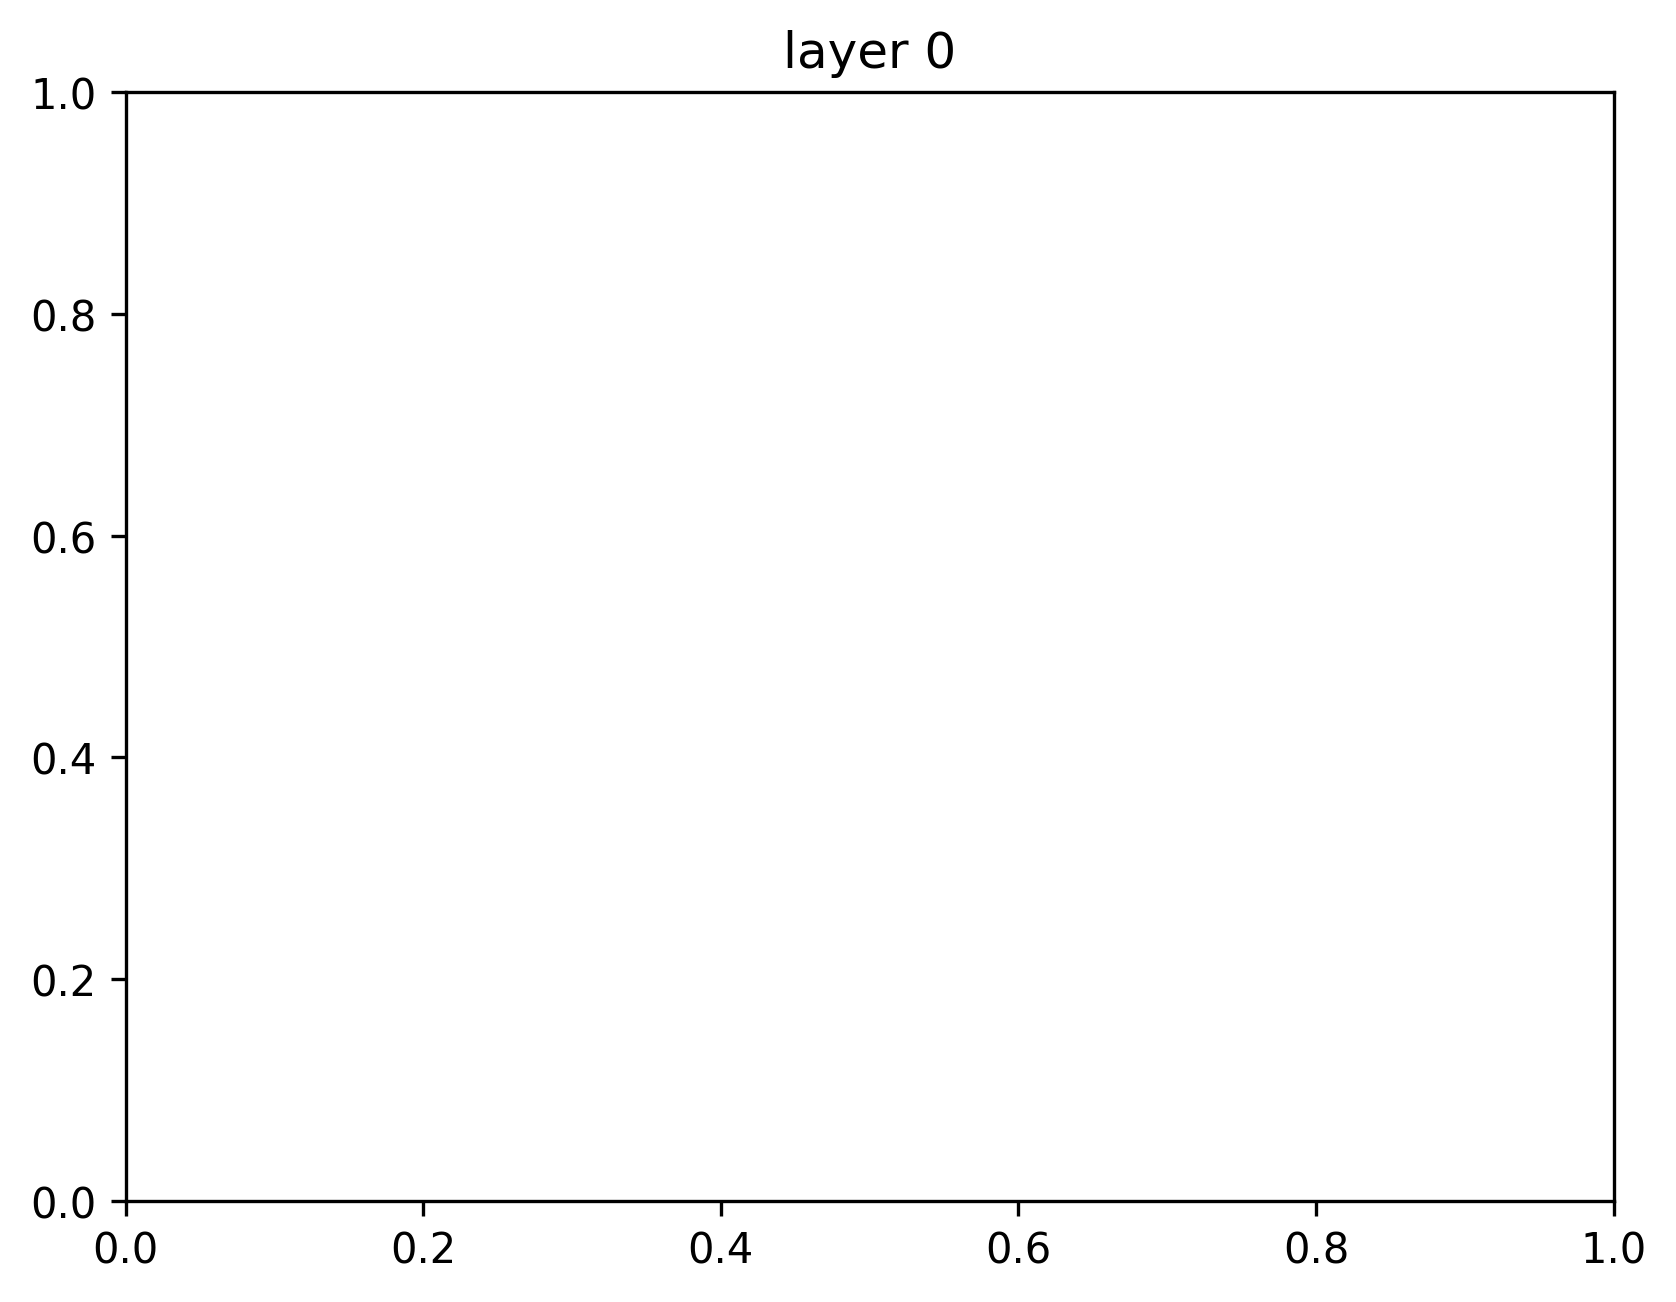

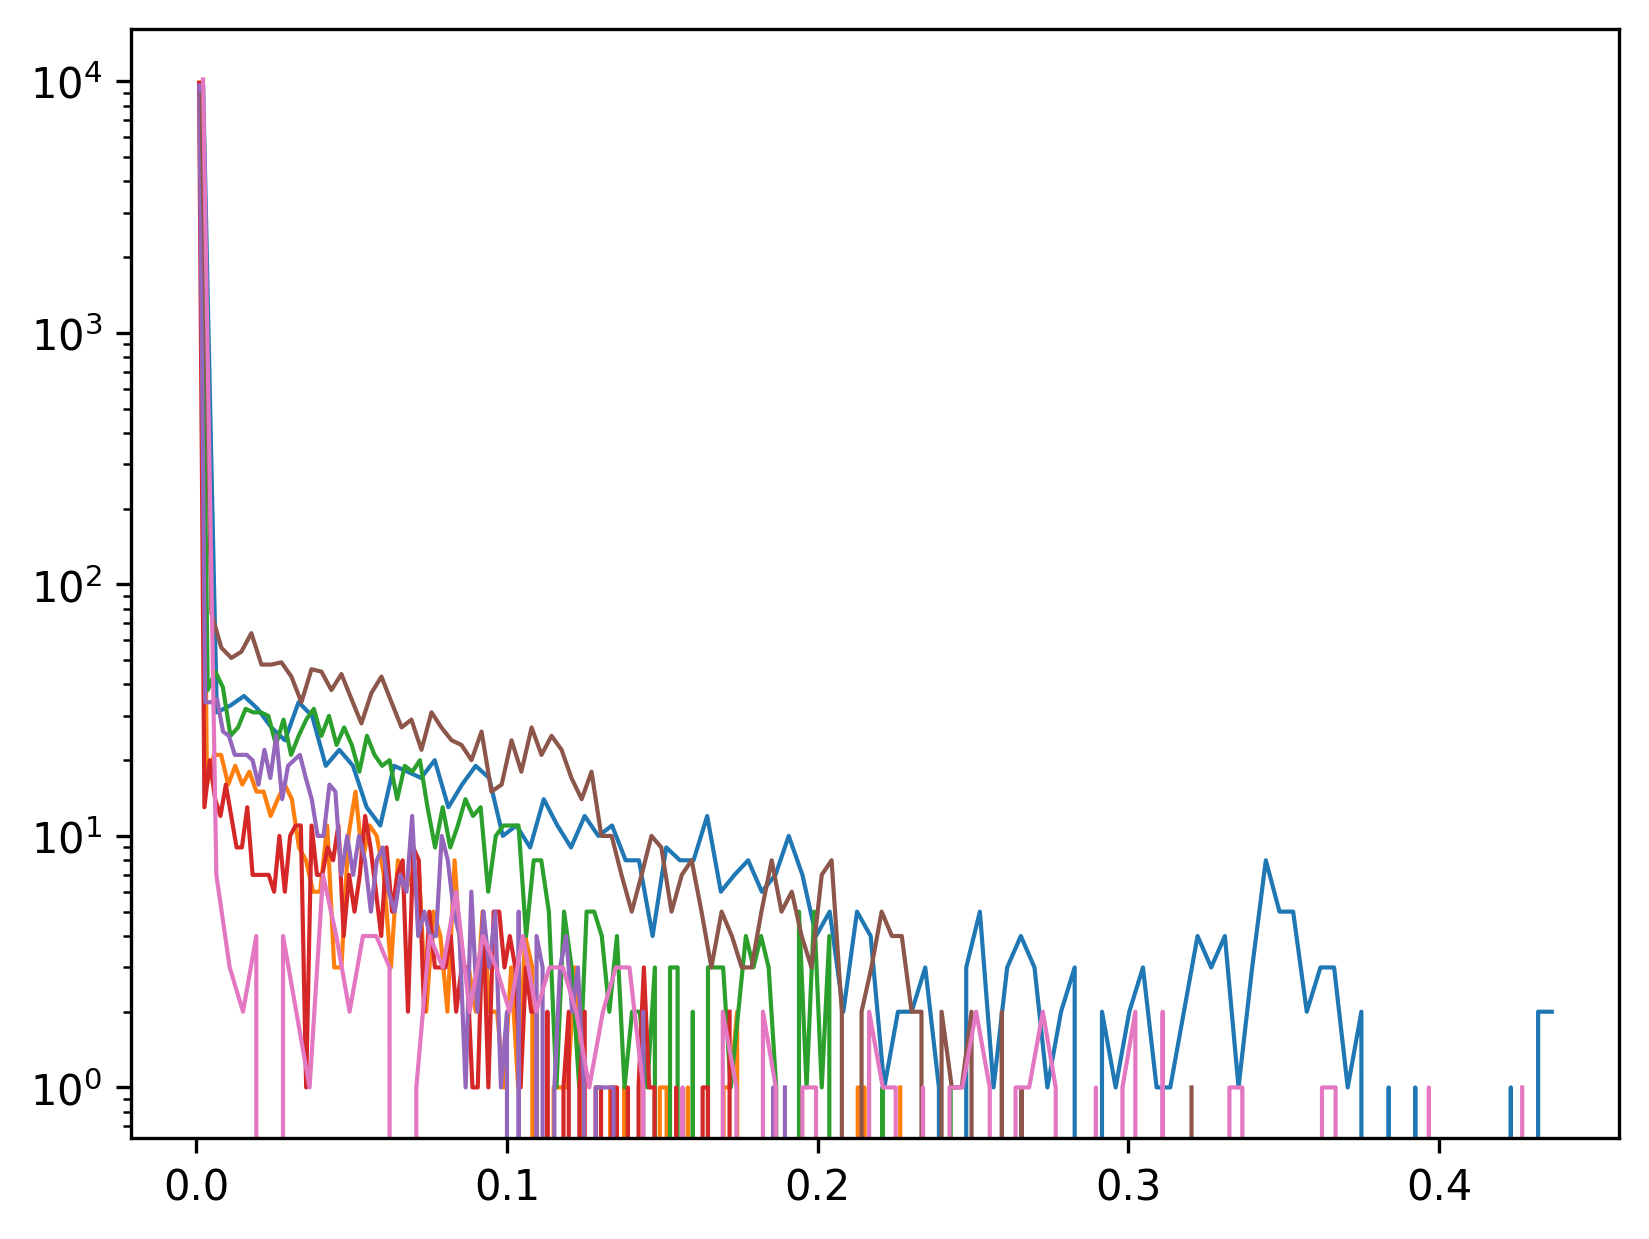

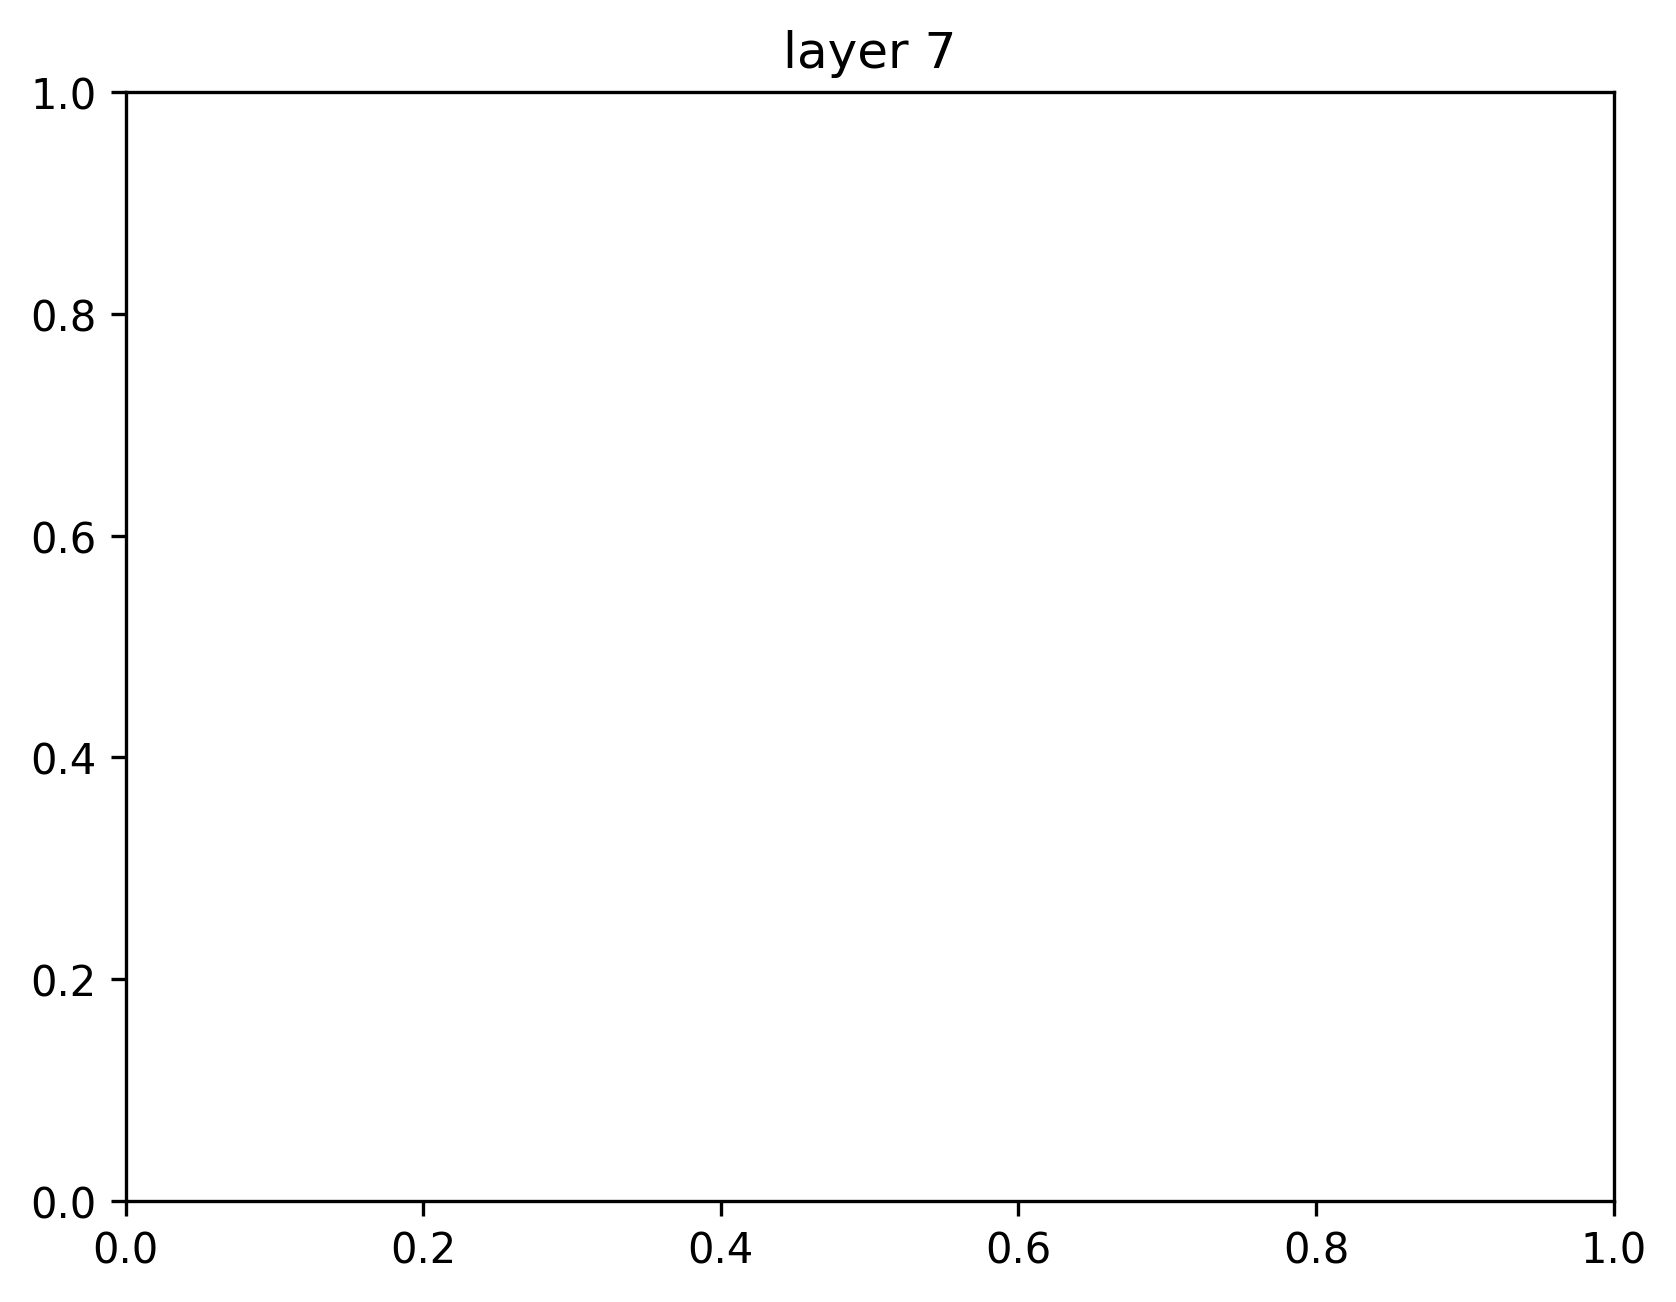

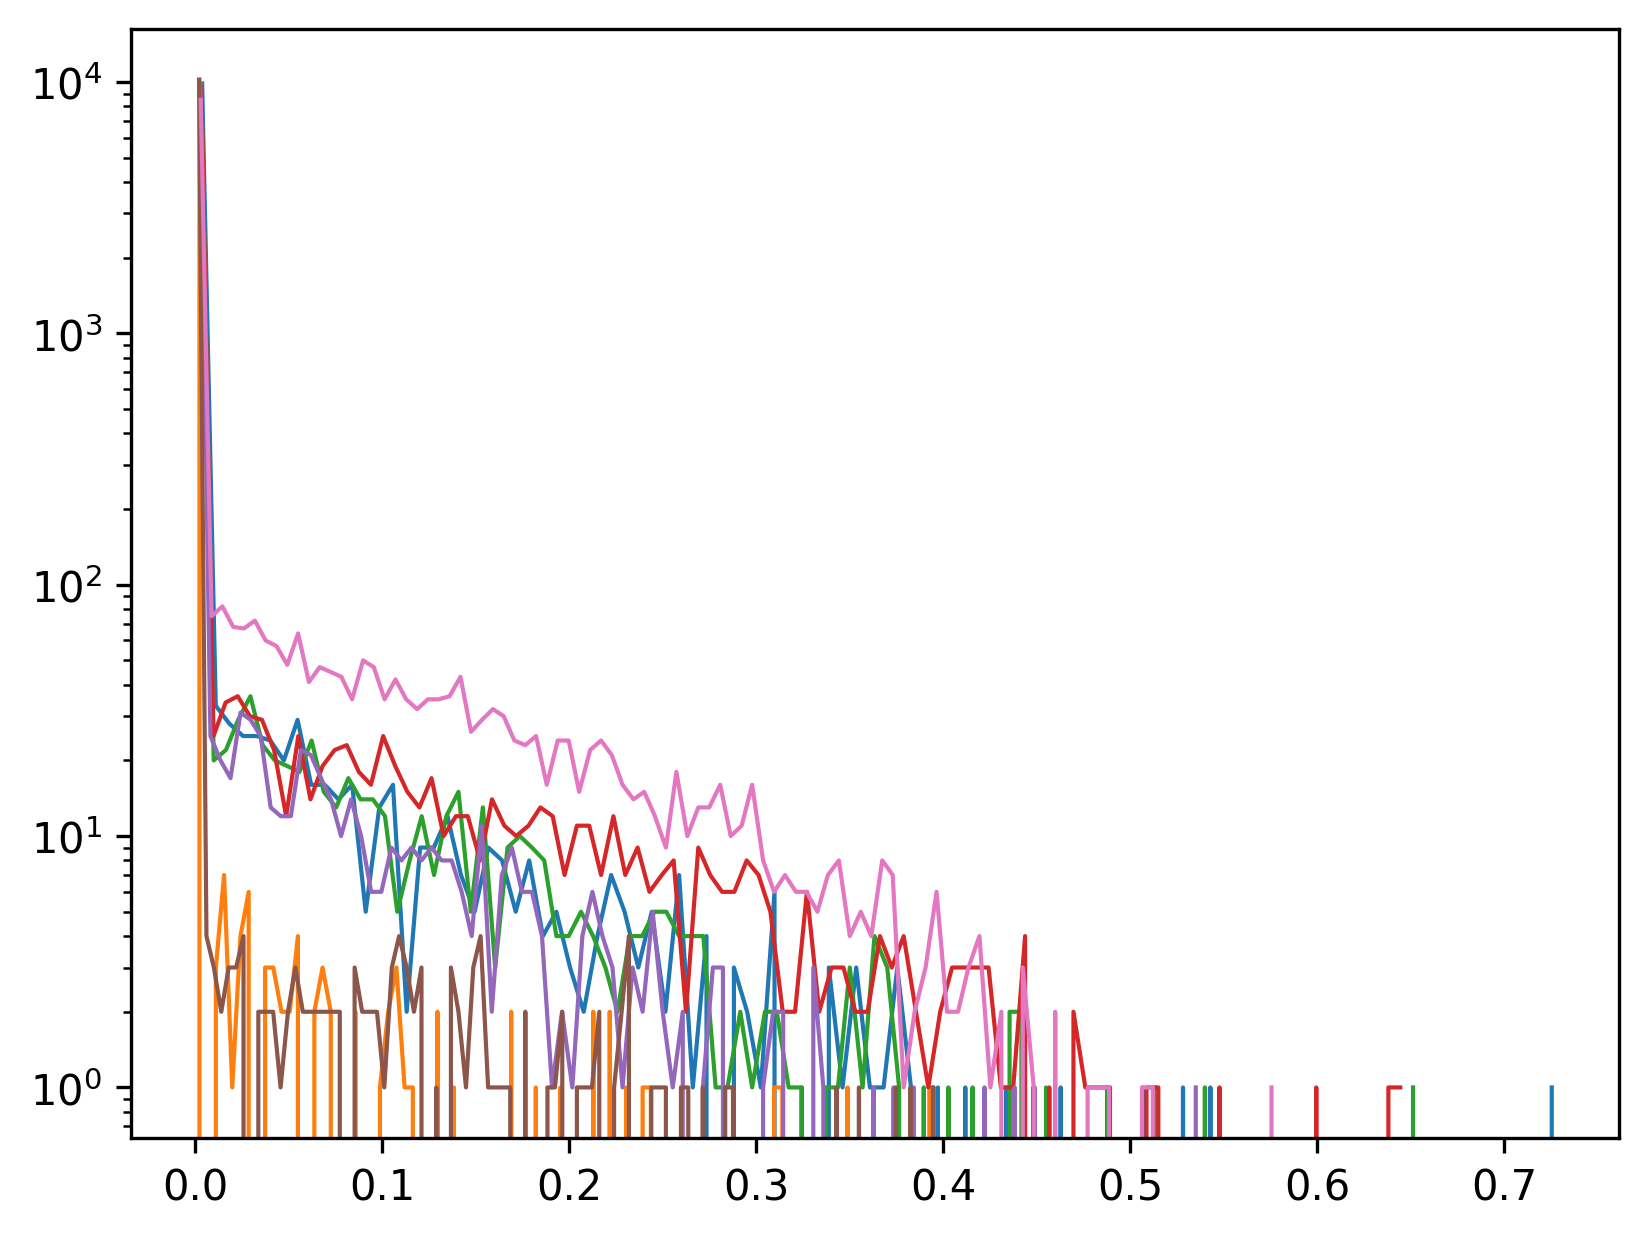

In [22]:
plot_activation_indices( ff_activations, [0, 10, 100, 200, 300, 400, 500 ] )

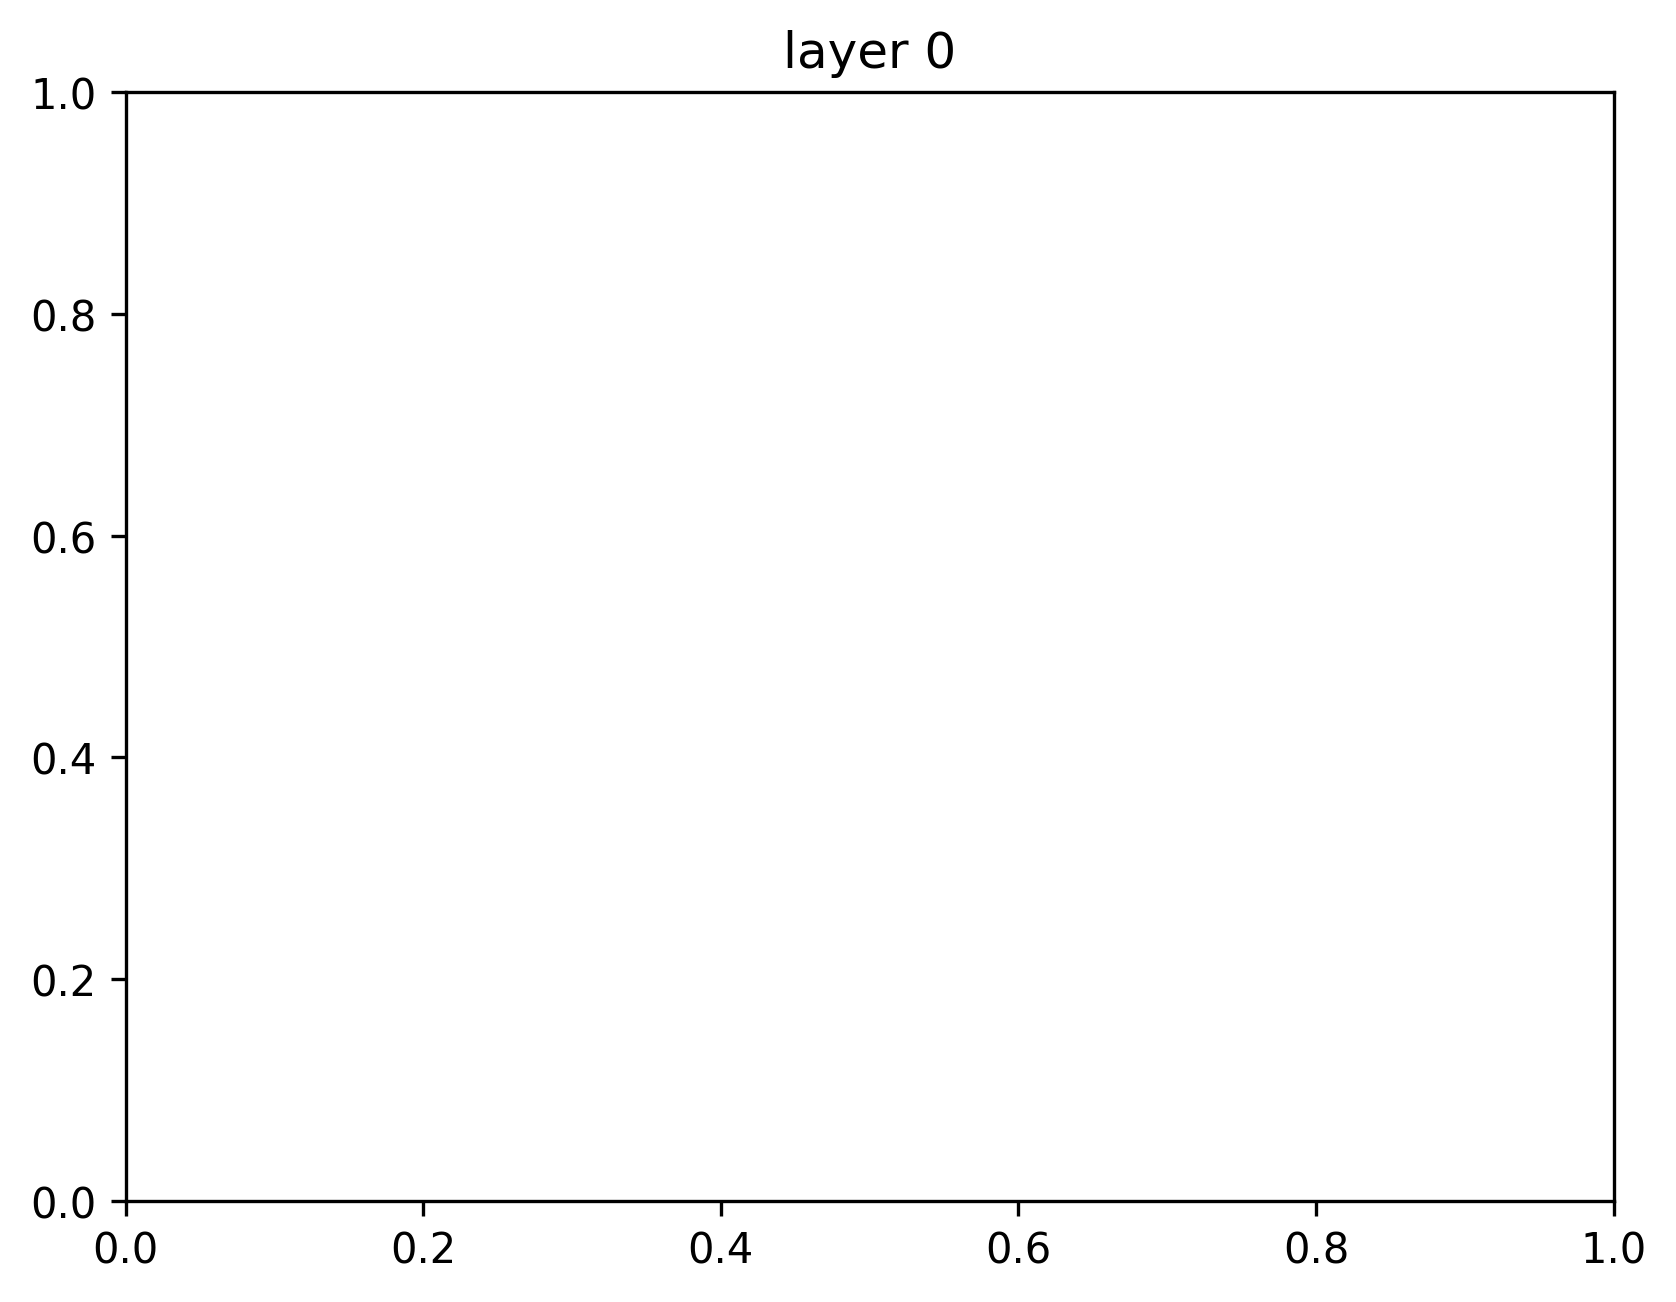

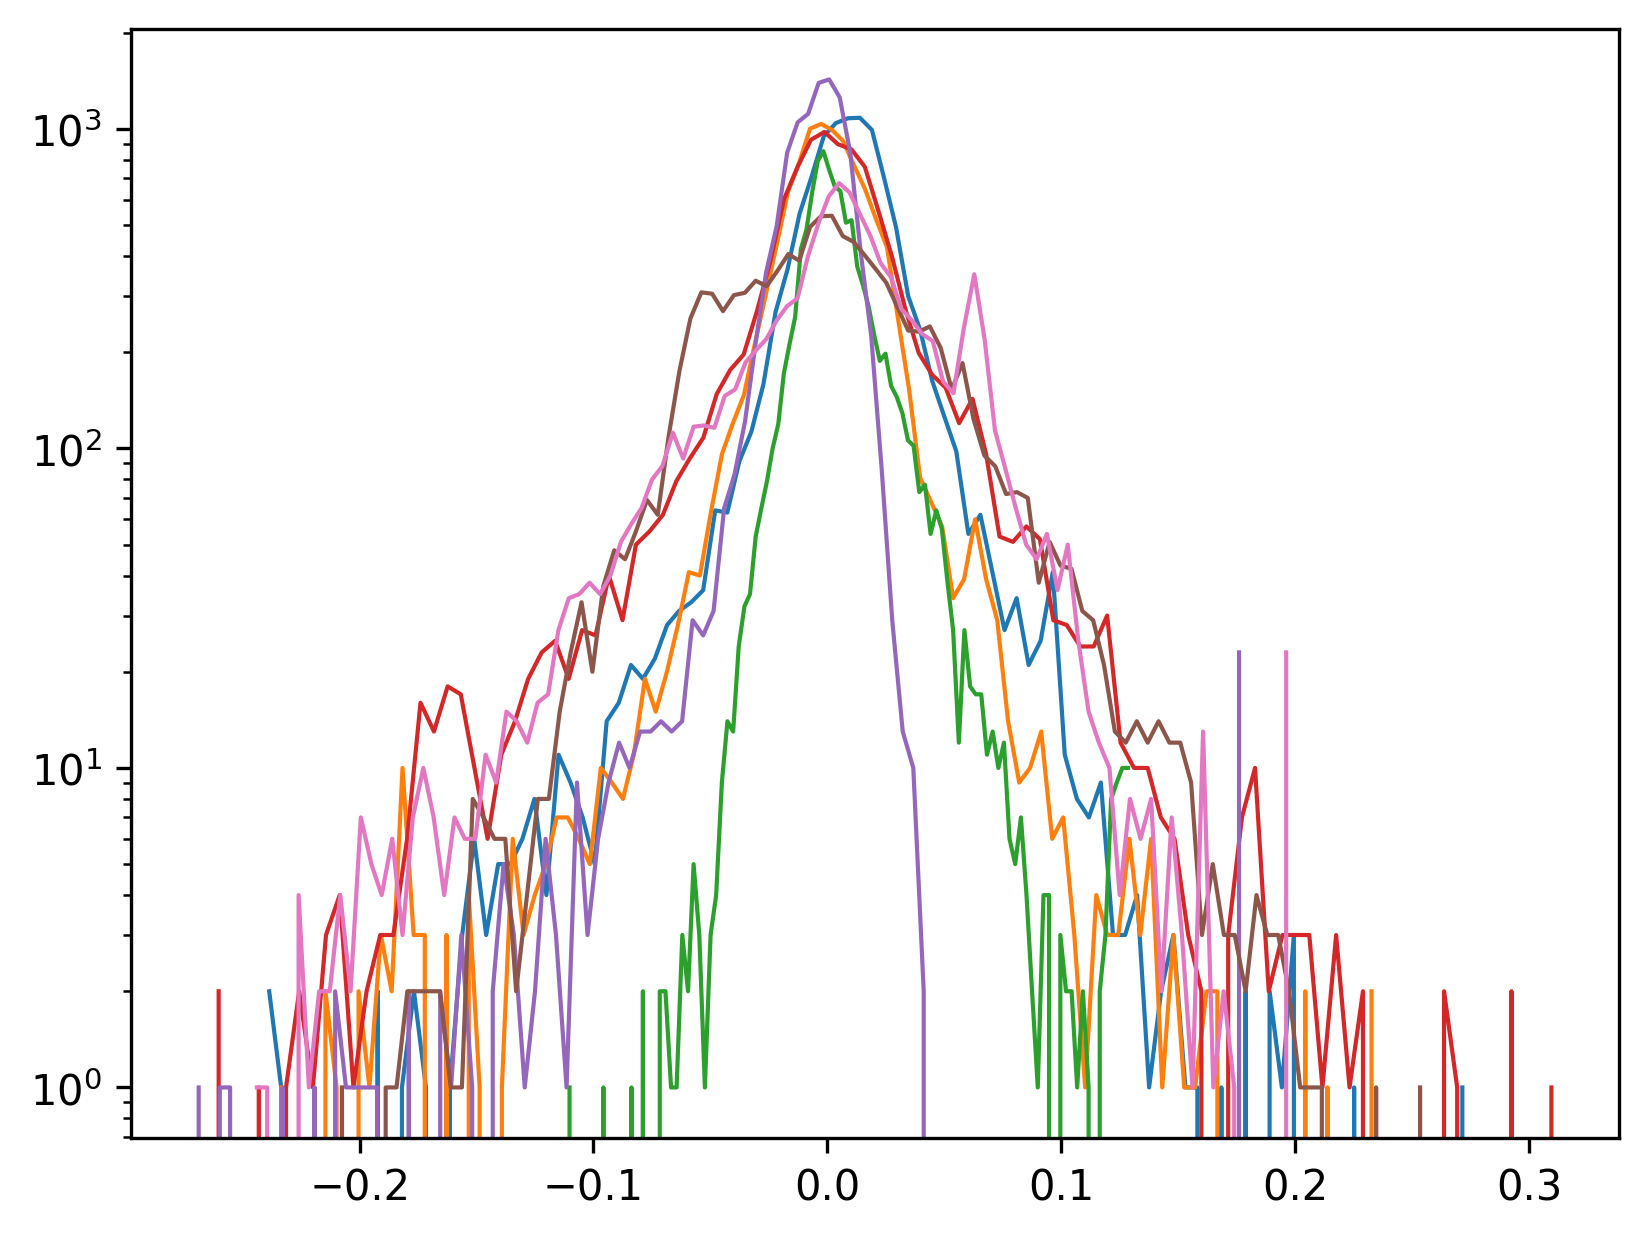

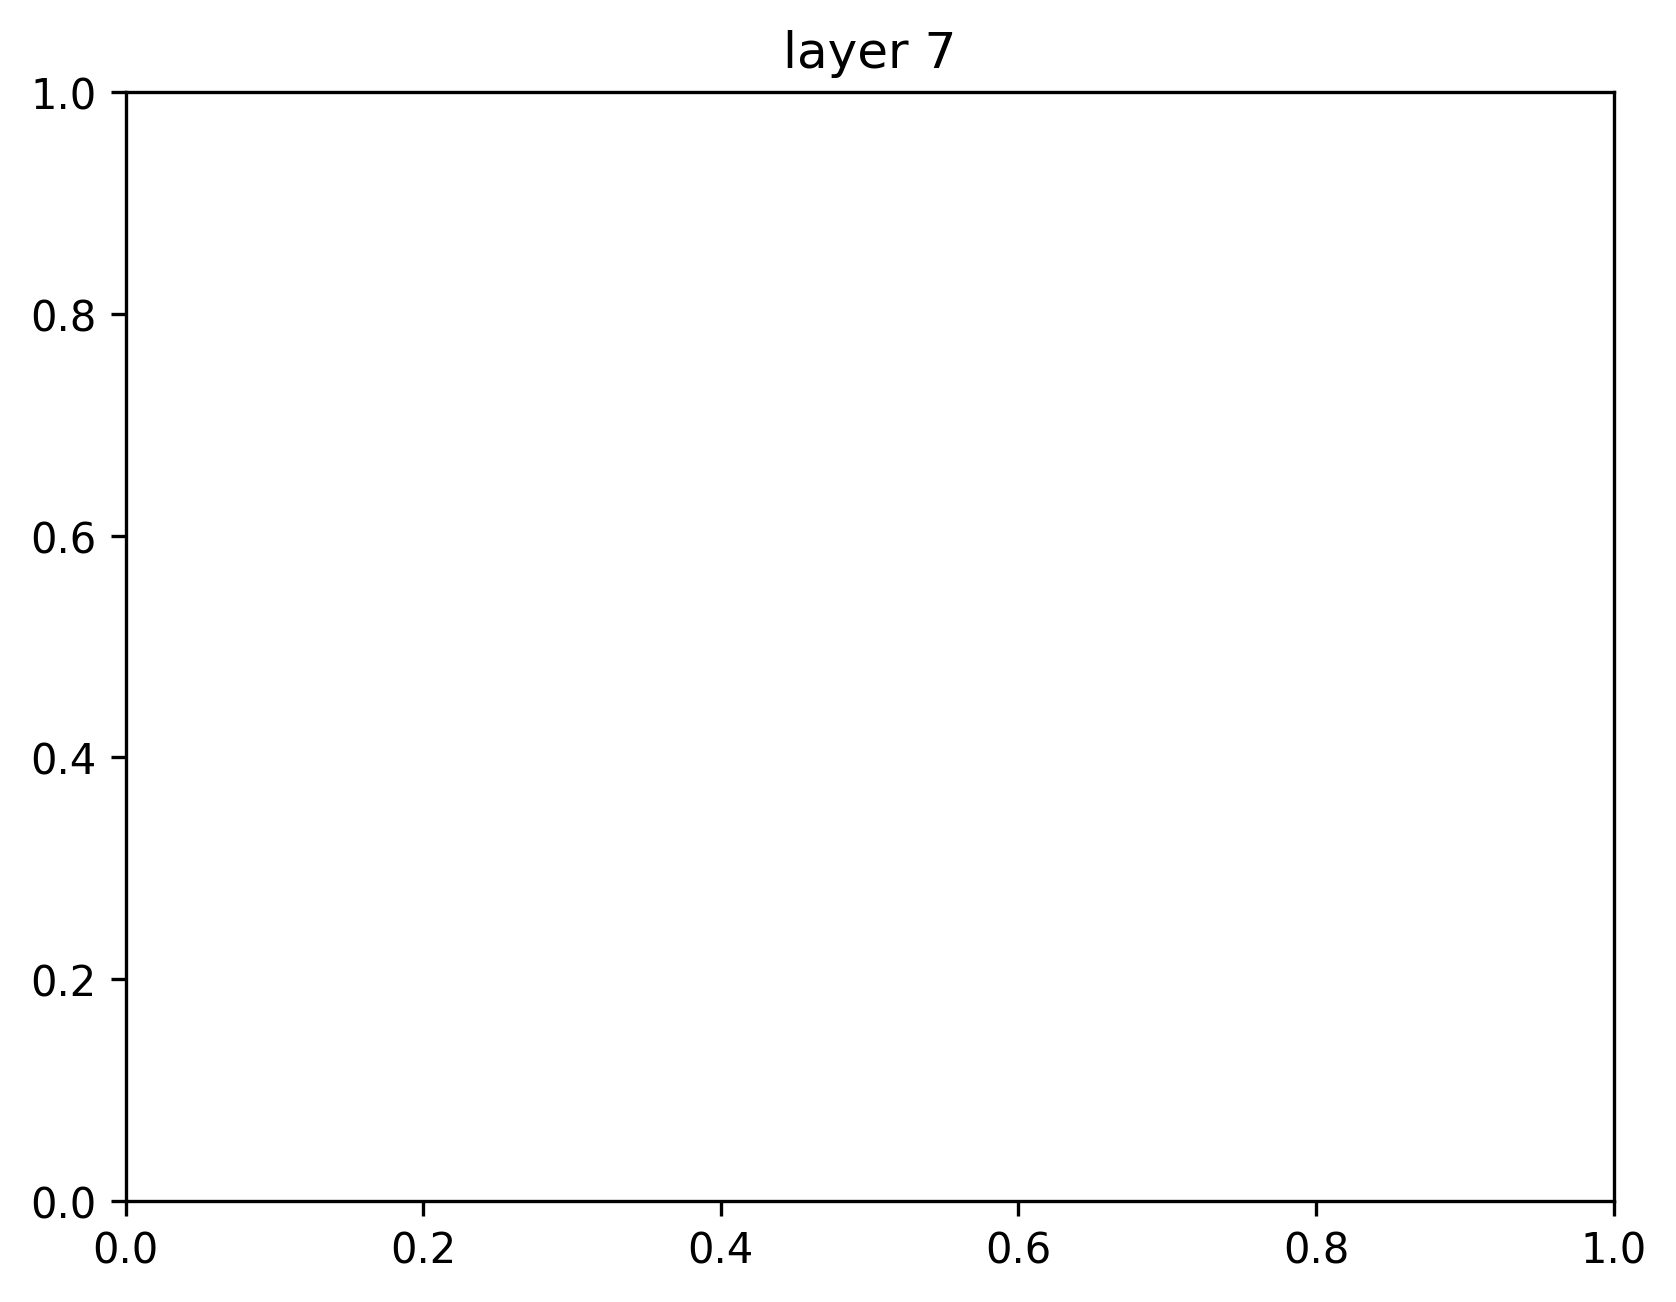

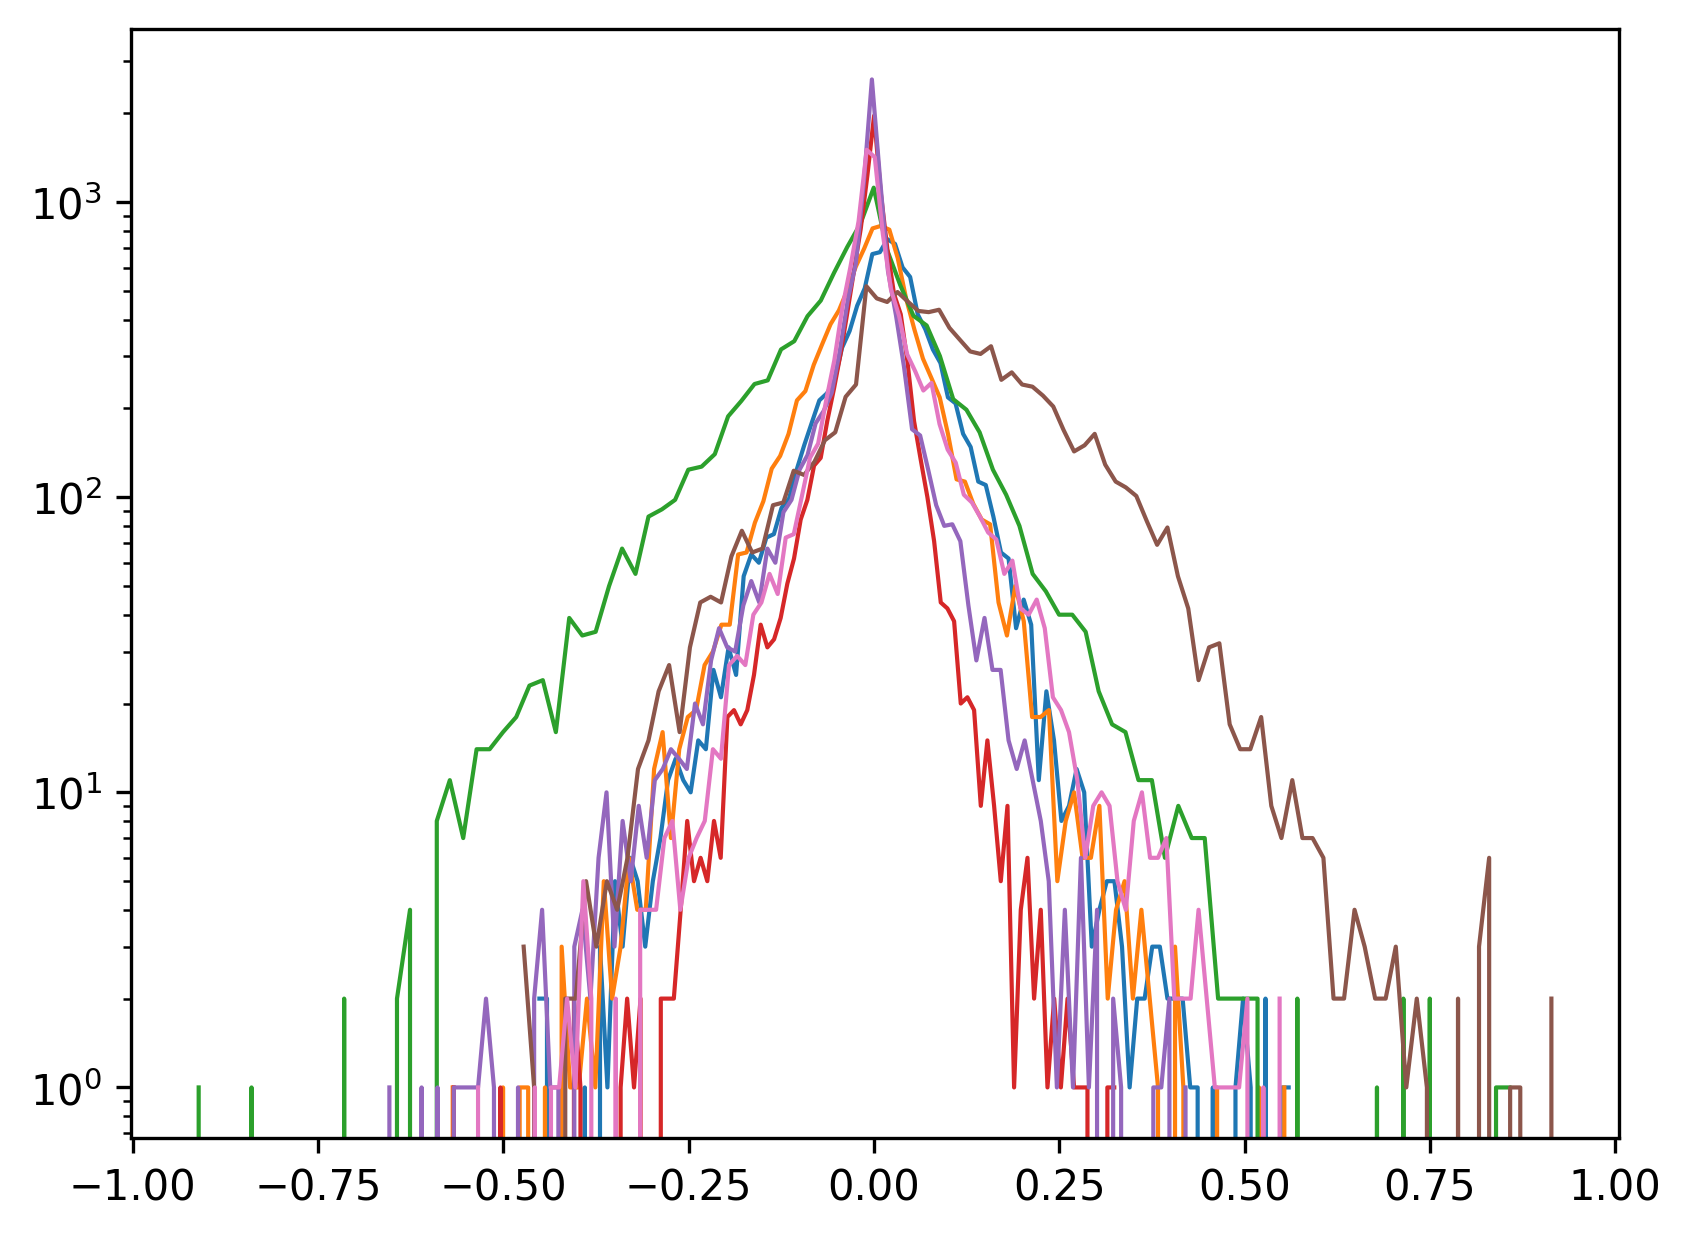

In [23]:

plot_activation_indices( attn_activations, [0, 10, 100, 200, 300, 400, 500 ] )

In [25]:
attn_means = torch.mean( attn_activations, dim=-1)
attn_indices = torch.sort( attn_means, dim=-1 ).indices.cpu().numpy()
indices = set([])
for i in range(opt.cfg.n_layers):
    indices.add( attn_indices[i][-1] )
    indices.add( attn_indices[i][-2] )
indices = np.sort( np.array(list(indices)) )
n_items = len(indices)

In [27]:
for j in range(opt.cfg.n_layers):
    break
    for i in indices:
        rgb = mpl.colors.hsv_to_rgb( (1, 1, i/n_items) )
        print( rgb )
        counts, bins = np.histogram( ff_activations[j][i].cpu().numpy(), bins=50 )
        mids = (bins[:-1] + bins[1:]) / 2
        plt.semilogy( mids, counts, label=f" dim {i}", color = rgb )
    plt.legend()
    plt.show()

In [28]:
pile_data = get_midlayer_activations( opt, "pile", 1e4, collect_ff=True, collect_attn=True )
code_data = get_midlayer_activations( opt, "code", 1e4, collect_ff=True, collect_attn=True )

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

10311it [00:17, 577.32it/s]                            
/home/ubuntu/taker/.venv/lib/python3.9/site-packages/datasets/load.py:1429: FutureWarning: The repository for codeparrot/github-code-clean contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/codeparrot/github-code-clean
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
10403it [00:17, 584.35it/s]                            


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/bin/bash: /home/ubuntu/taker/.venv/bin/pip: /home/ubuntu/untape/.venv/bin/python: bad interpreter: No such file or directory


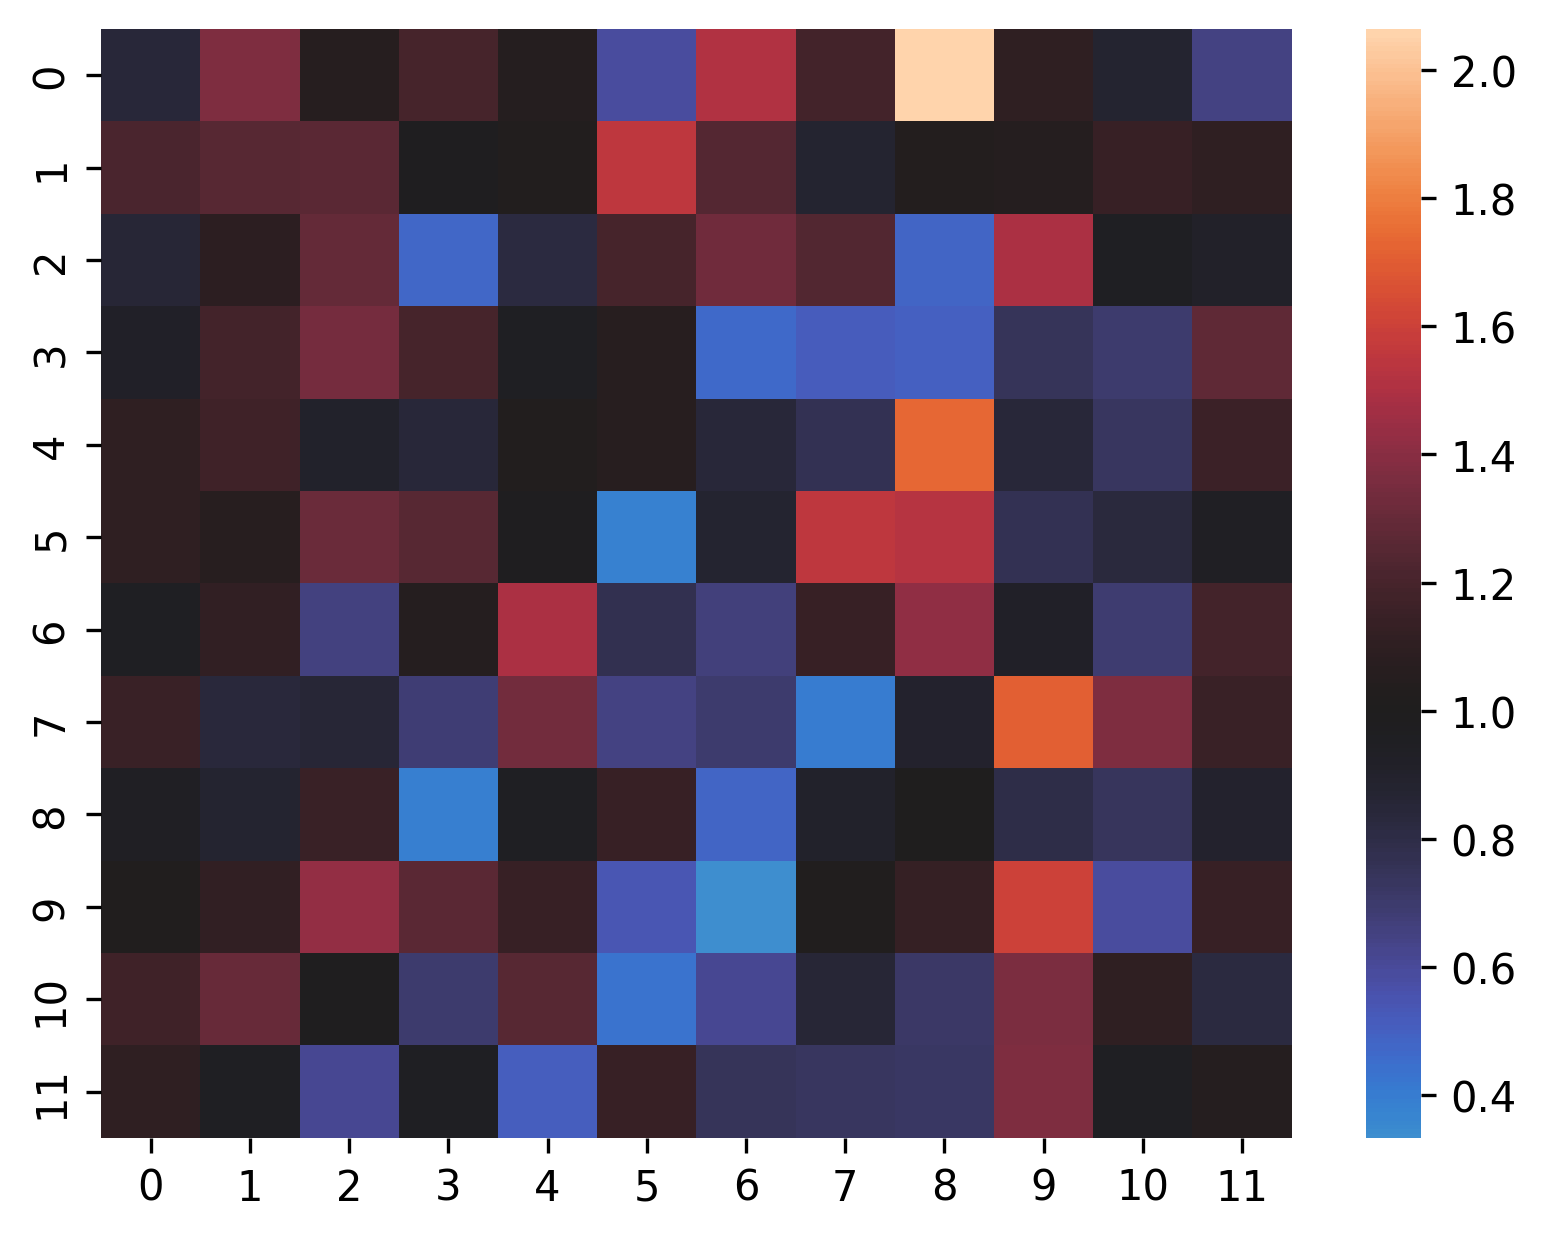

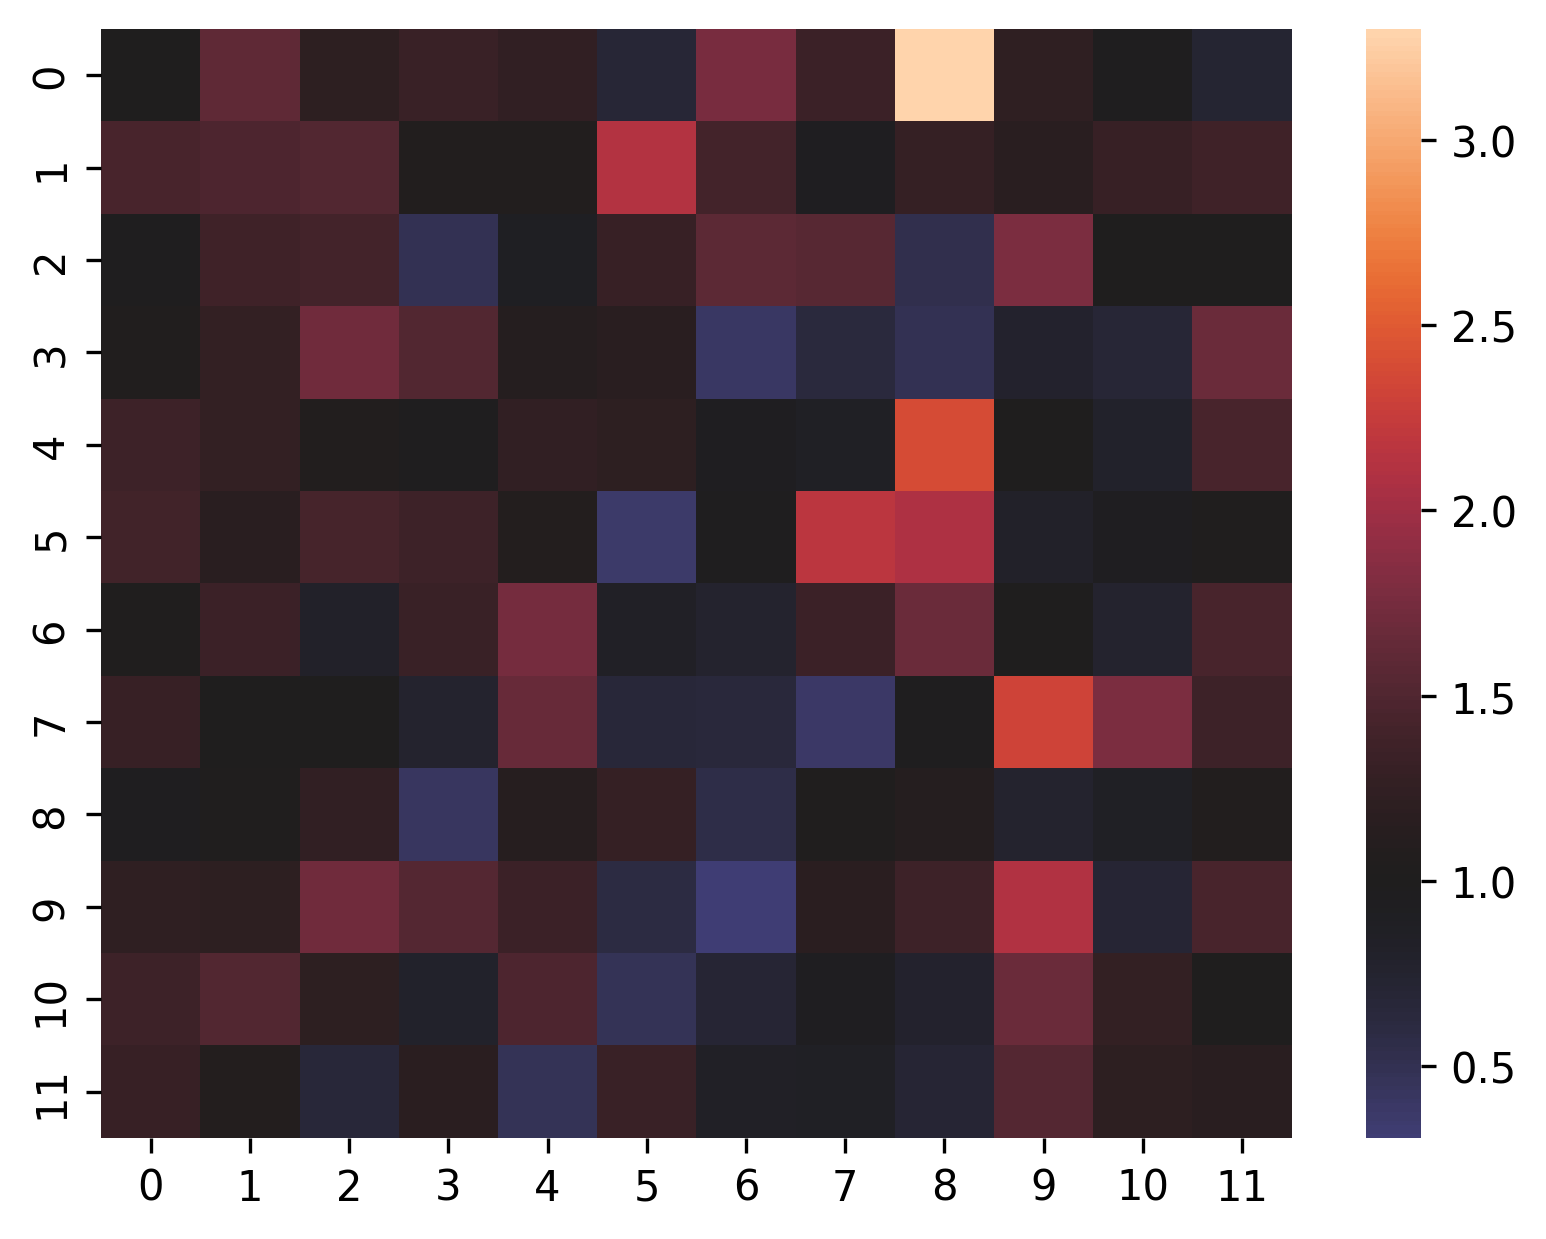

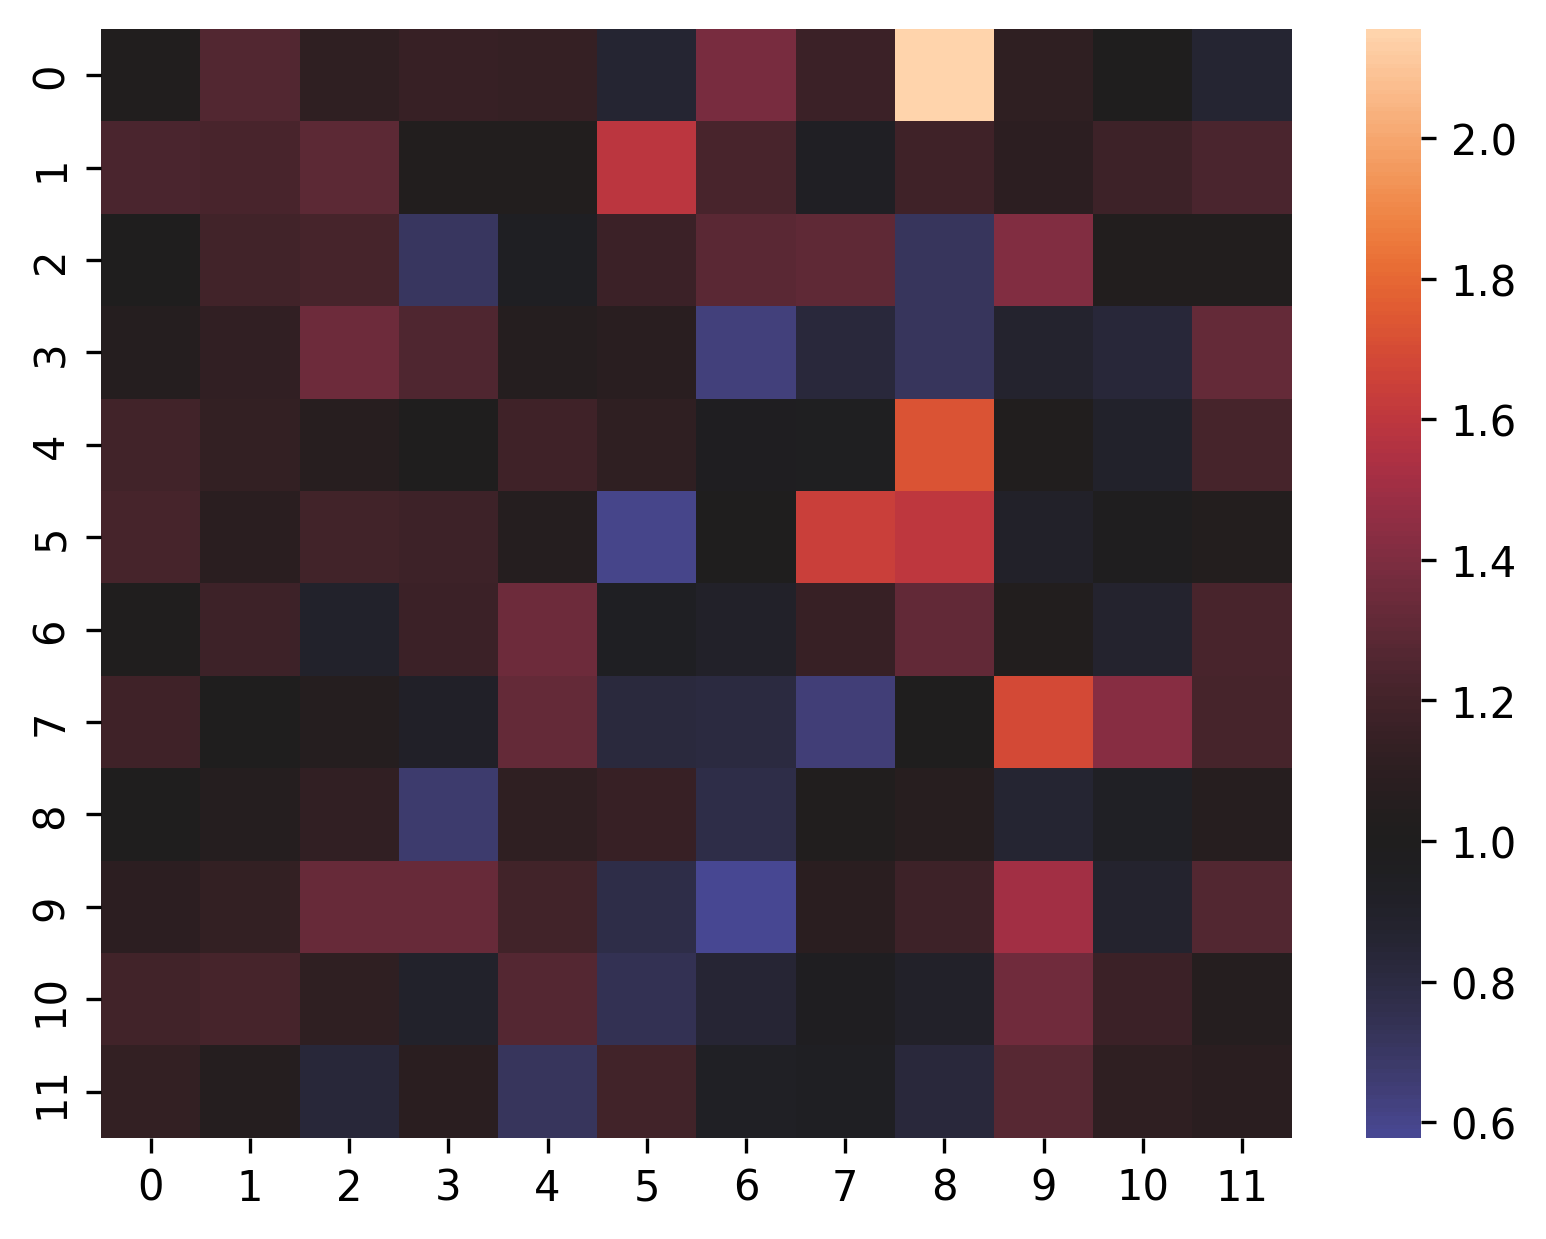

In [30]:
! pip install seaborn -q
import seaborn as sns

metric1 = lambda x: x.std(dim=0)
metric2 = lambda x: x.abs().mean(dim=0)
metric3 = lambda x: x.abs().sqrt().mean(dim=0)
def ratio( cripple, focus, metric ):
    top    = metric( cripple.raw["attn"] )
    bottom = metric( focus.raw["attn"] ) + 1e-6
    return top / bottom

for metric in [metric1, metric2, metric3]:
    std_ratios = ratio( code_data, pile_data, metric )
    # std_ratio_means = std_ratios.mean(dim=-1)
    std_ratio_medians = torch.quantile(
        std_ratios.to(dtype=torch.float32), q=0.5, dim=-1)

    plt.figure()
    sns.heatmap(std_ratio_medians.T, center=1)

In [32]:
pile_attn = pile_data.raw["attn"].permute( (1,2,3,0) )
code_attn = code_data.raw["attn"].permute( (1,2,3,0) )

def plot_attn_head_neurons(i_layer, i_head, clamp=0.4):
    pile_head = pile_attn[i_layer, i_head].clamp(-clamp, clamp)
    code_head = code_attn[i_layer, i_head].clamp(-clamp, clamp)

    bins = lambda x: (x.bin_edges[1:] + x.bin_edges[:-1]) / 2
    normed_hist = lambda x: x.hist * ( 1e-6 * 1 /(x.bin_edges[1]-x.bin_edges[0]))

    fig, axes = plt.subplots(8, 1, figsize=(8,16))
    axes[0].set_title("Attention Head")
    for i in range(0, 8):
        ax = axes[i]
        pile_hist = pile_head[i].histogram(200)
        code_hist = code_head[i].histogram(200)
        ax.semilogy( bins(pile_hist), normed_hist(pile_hist), label="pile" )
        ax.semilogy( bins(code_hist), normed_hist(code_hist), label="code" )
    plt.legend()

    plt.show()

In [34]:
plot_attn_head_neurons(15, 12, 0.4)
plot_attn_head_neurons(15, 26, 0.4)
plot_attn_head_neurons(18, 26, 0.4)
plot_attn_head_neurons(19,  6, 0.4)
plot_attn_head_neurons(21, 23, 0.4)

#plot_attn_head_neurons(16,  9, 0.4)
#plot_attn_head_neurons(17,  3, 0.4)
#plot_attn_head_neurons(22, 10, 0.2)
#plot_attn_head_neurons(23, 22, 0.4)

IndexError: index 12 is out of bounds for dimension 1 with size 12